# Hierarchical Pricing Elasticity Models

In this notebook we use a retail publicly available dataset to fit and compare various pricing elasticity models. This example can be seen as a continuation of the notebooks regarding Bayesian hierarchical models (see for example [Multilevel Elasticities for a Single SKU - Part I](https://juanitorduz.github.io/multilevel_elasticities_single_sku/)). In this example we also see how Bayesian hierarchical models can help regularize elasticity estimates when taking advantage of the hierarchical structure of the data. In addition, this example shows that these models can scale well using stochastic variational inference in [NumPyro](https://github.com/pyro-ppl/numpyro).

## Prepare Notebook

In [1]:
import arviz as az
import graphviz as gr
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import polars as pl
import seaborn as sns
from jax import random
from numpyro.handlers import block, reparam, seed
from numpyro.infer import SVI
from numpyro.infer.autoguide import (
    AutoGuideList,
    AutoMultivariateNormal,
    AutoNormal,
    Predictive,
    Trace_ELBO,
)
from numpyro.infer.reparam import LocScaleReparam
from sklearn.preprocessing import LabelEncoder

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Read Data

The dataset we use is available in the [Kaggle](https://www.kaggle.com/) page [Retail Scanner Data: Gauge Price Elasticity](https://www.kaggle.com/datasets/marian447/retail-store-sales-transactions). From the dataset documentation:

> Detailed data on sales of consumer goods obtained by ‘scanning’ the bar codes for individual products at electronic points of sale in a retail store. The data provide detailed information about quantities, characteristics and values of goods sold as well as their prices.
>
> The anonymized dataset includes 64.682 transactions of 5.242 SKU's sold to 22.625 customers during one year.
>
> - Dataset Description
> - Date of Sales Transaction
> - Customer ID
> - Transaction ID
> - SKU Category ID
> - SKU ID
> - Quantity Sold
> - Sales Amount (Unit price times quantity. For unit price, please divide Sales Amount by Quantity.)


Let's read the data into a [Polars](https://docs.pola.rs/) DataFrame.

In [2]:
raw_data_df = pl.read_csv(
    "../data/scanner_data.csv",  # Path to the dataset (locally)
    columns=[
        "Date",
        "Customer_ID",
        "Transaction_ID",
        "SKU_Category",
        "SKU",
        "Quantity",
        "Sales_Amount",
    ],
    schema_overrides={"Date": pl.Date(), "Quantity": pl.Float64()},
)

raw_data_df.head()

Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
date,i64,i64,str,str,f64,f64
2016-01-02,2547,1,"""X52""","""0EM7L""",1.0,3.13
2016-01-02,822,2,"""2ML""","""68BRQ""",1.0,5.46
2016-01-02,3686,3,"""0H2""","""CZUZX""",1.0,6.35
2016-01-02,3719,4,"""0H2""","""549KK""",1.0,5.59
2016-01-02,9200,5,"""0H2""","""K8EHH""",1.0,6.88


## Process Data

We star with a very simple formatting step.

In [3]:
data_df = (
    raw_data_df.select(pl.all().name.to_lowercase())
    .with_columns(
        # Compute price as sales_amount / quantity
        pl.col("sales_amount").truediv(pl.col("quantity")).alias("price")
    )
    .drop(["customer_id", "transaction_id"])
)

data_df.head()

date,sku_category,sku,quantity,sales_amount,price
date,str,str,f64,f64,f64
2016-01-02,"""X52""","""0EM7L""",1.0,3.13,3.13
2016-01-02,"""2ML""","""68BRQ""",1.0,5.46,5.46
2016-01-02,"""0H2""","""CZUZX""",1.0,6.35,6.35
2016-01-02,"""0H2""","""549KK""",1.0,5.59,5.59
2016-01-02,"""0H2""","""K8EHH""",1.0,6.88,6.88


## Exploratory Data Analysis

This dataset has many good exploratory data analysis notebooks on the [Kaggle page](https://docs.pola.rs/). Here we focus on the most important aspect in order to fit a pricing elasticity model.

We start by counting the number of SKUs and SKUs categories.


In [4]:
print(f"Number of SKUs: {data_df['sku'].n_unique()}")
print(f"Number of SKUs Categories: {data_df['sku_category'].n_unique()}")

Number of SKUs: 5242
Number of SKUs Categories: 187


We are interested in the number of SKUs per category. We can count them ant plot the top 25 categories.

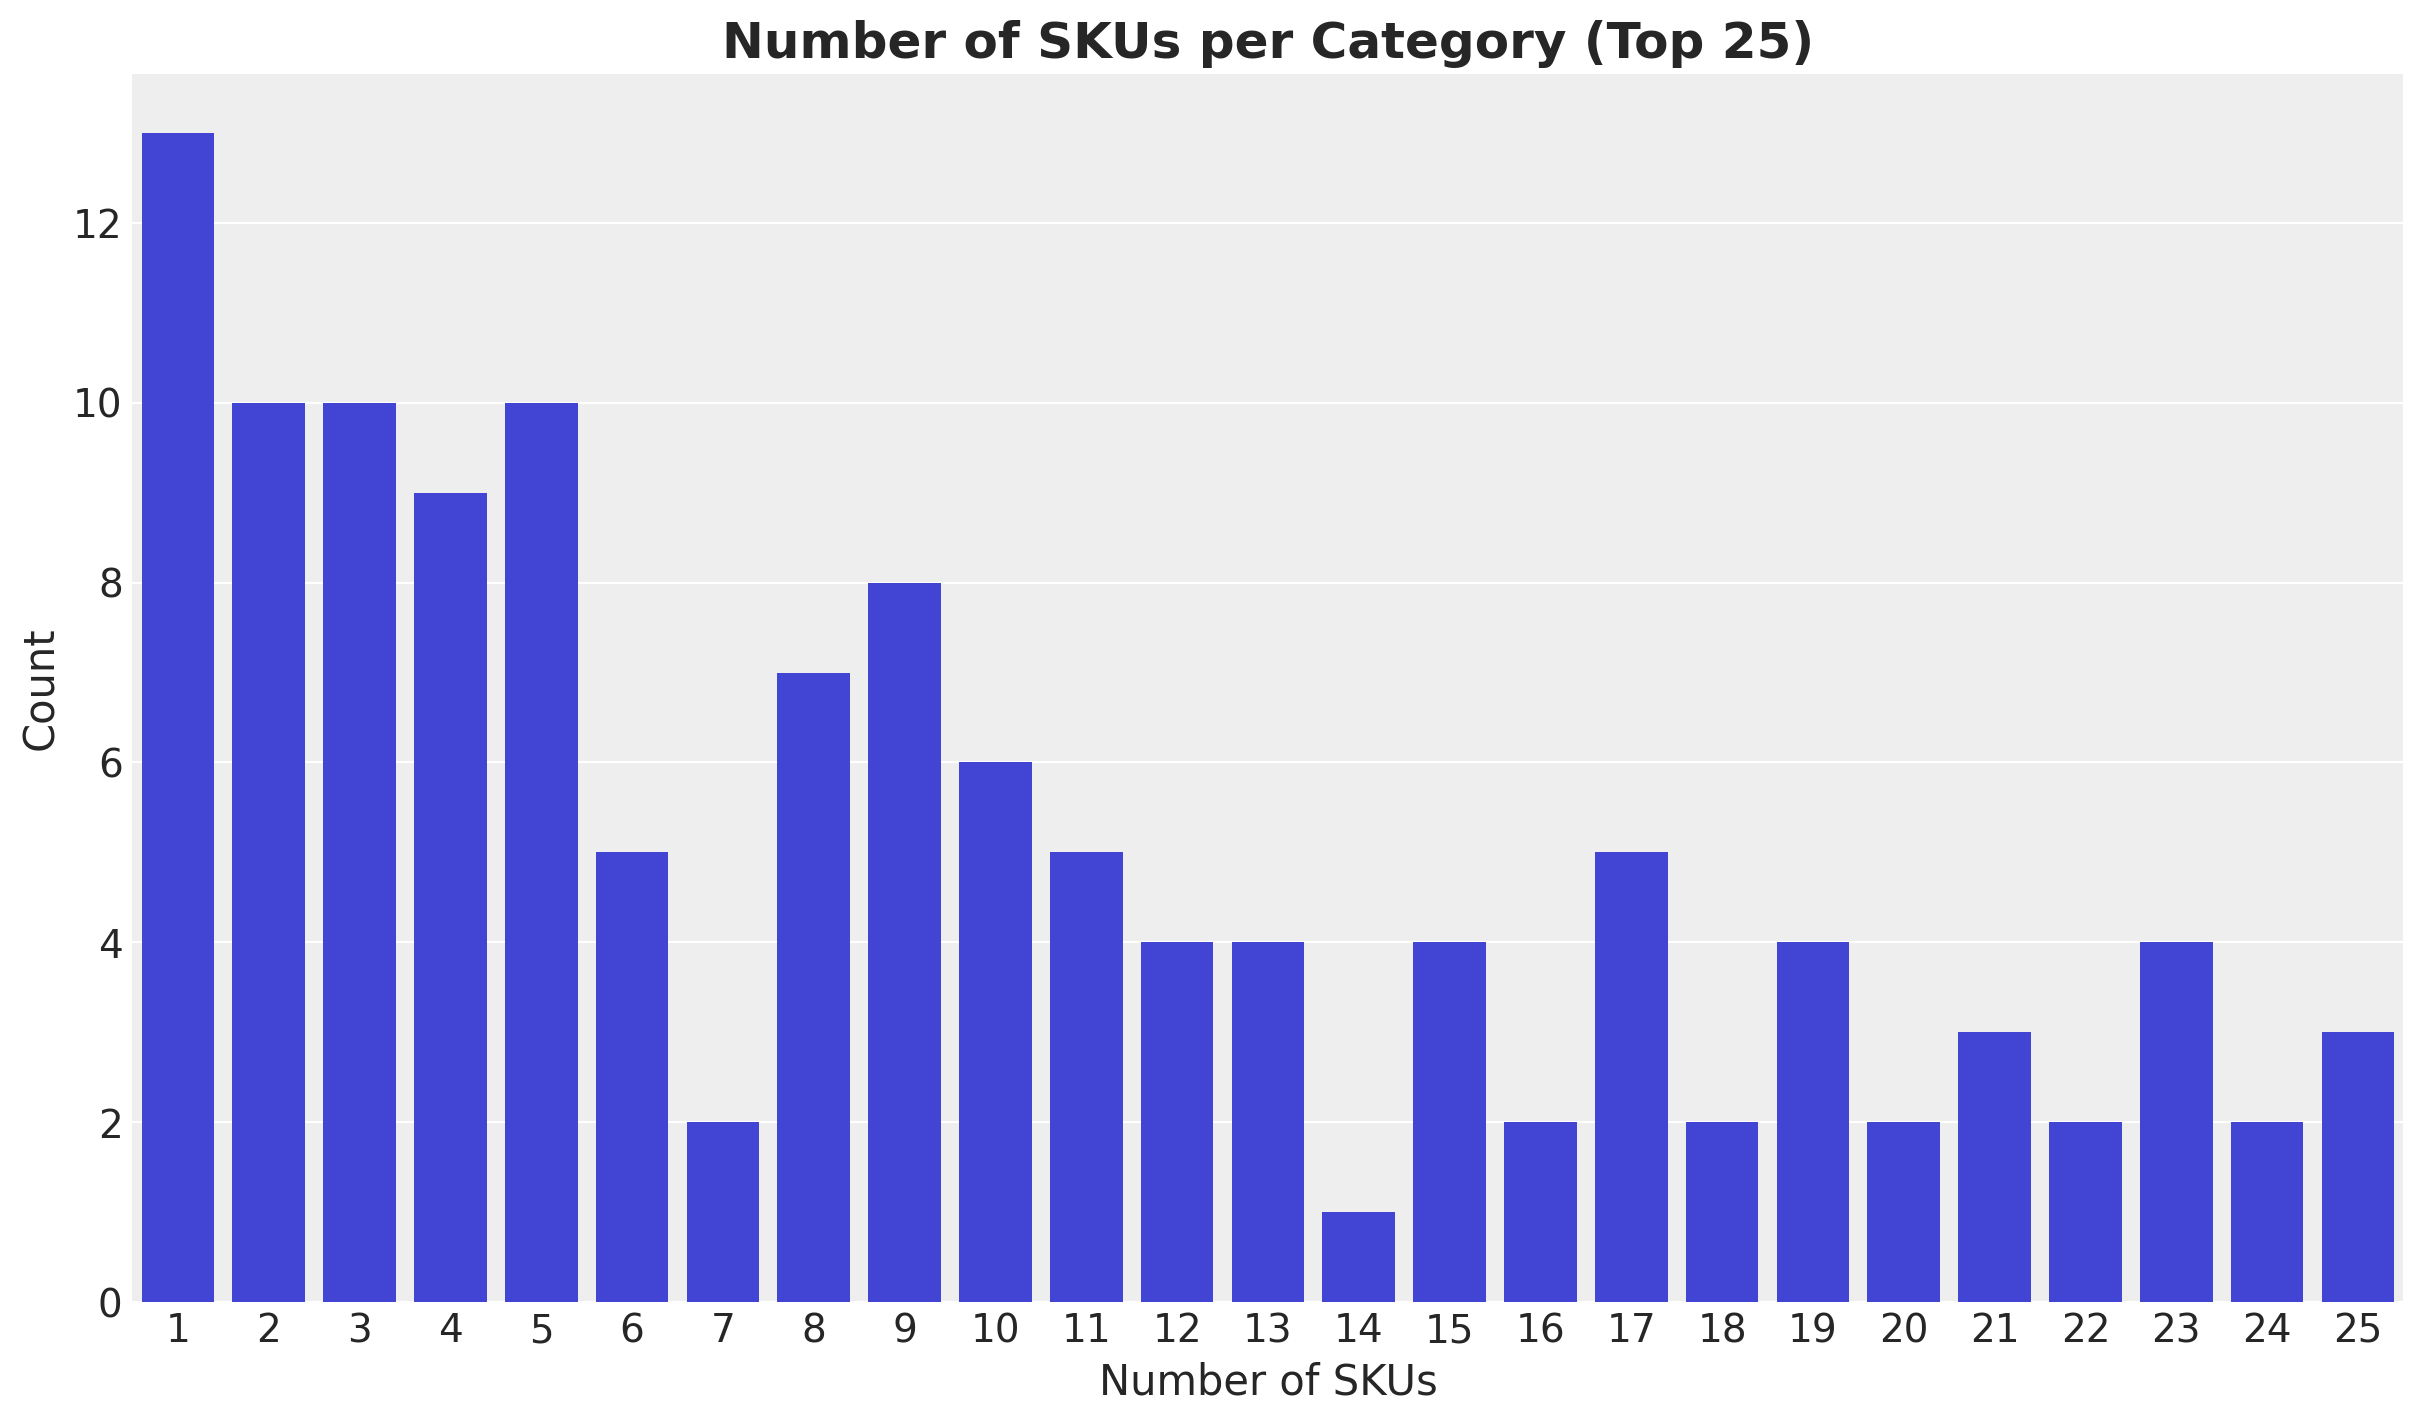

In [5]:
fig, ax = plt.subplots()
sns.barplot(
    data=data_df.group_by("sku_category")
    .agg(pl.col("sku").n_unique().alias("n_skus"))
    .group_by("n_skus")
    .len()
    .sort("n_skus")
    .head(25),
    x="n_skus",
    y="len",
    ax=ax,
)
ax.set(xlabel="Number of SKUs", ylabel="Count")
ax.set_title("Number of SKUs per Category (Top 25)", fontsize=18, fontweight="bold");

Hence, we see that on average the SKU categories are rather small with of the order of $1 - 10$ SKUs.

Next, we plot the aggregated sales over time.

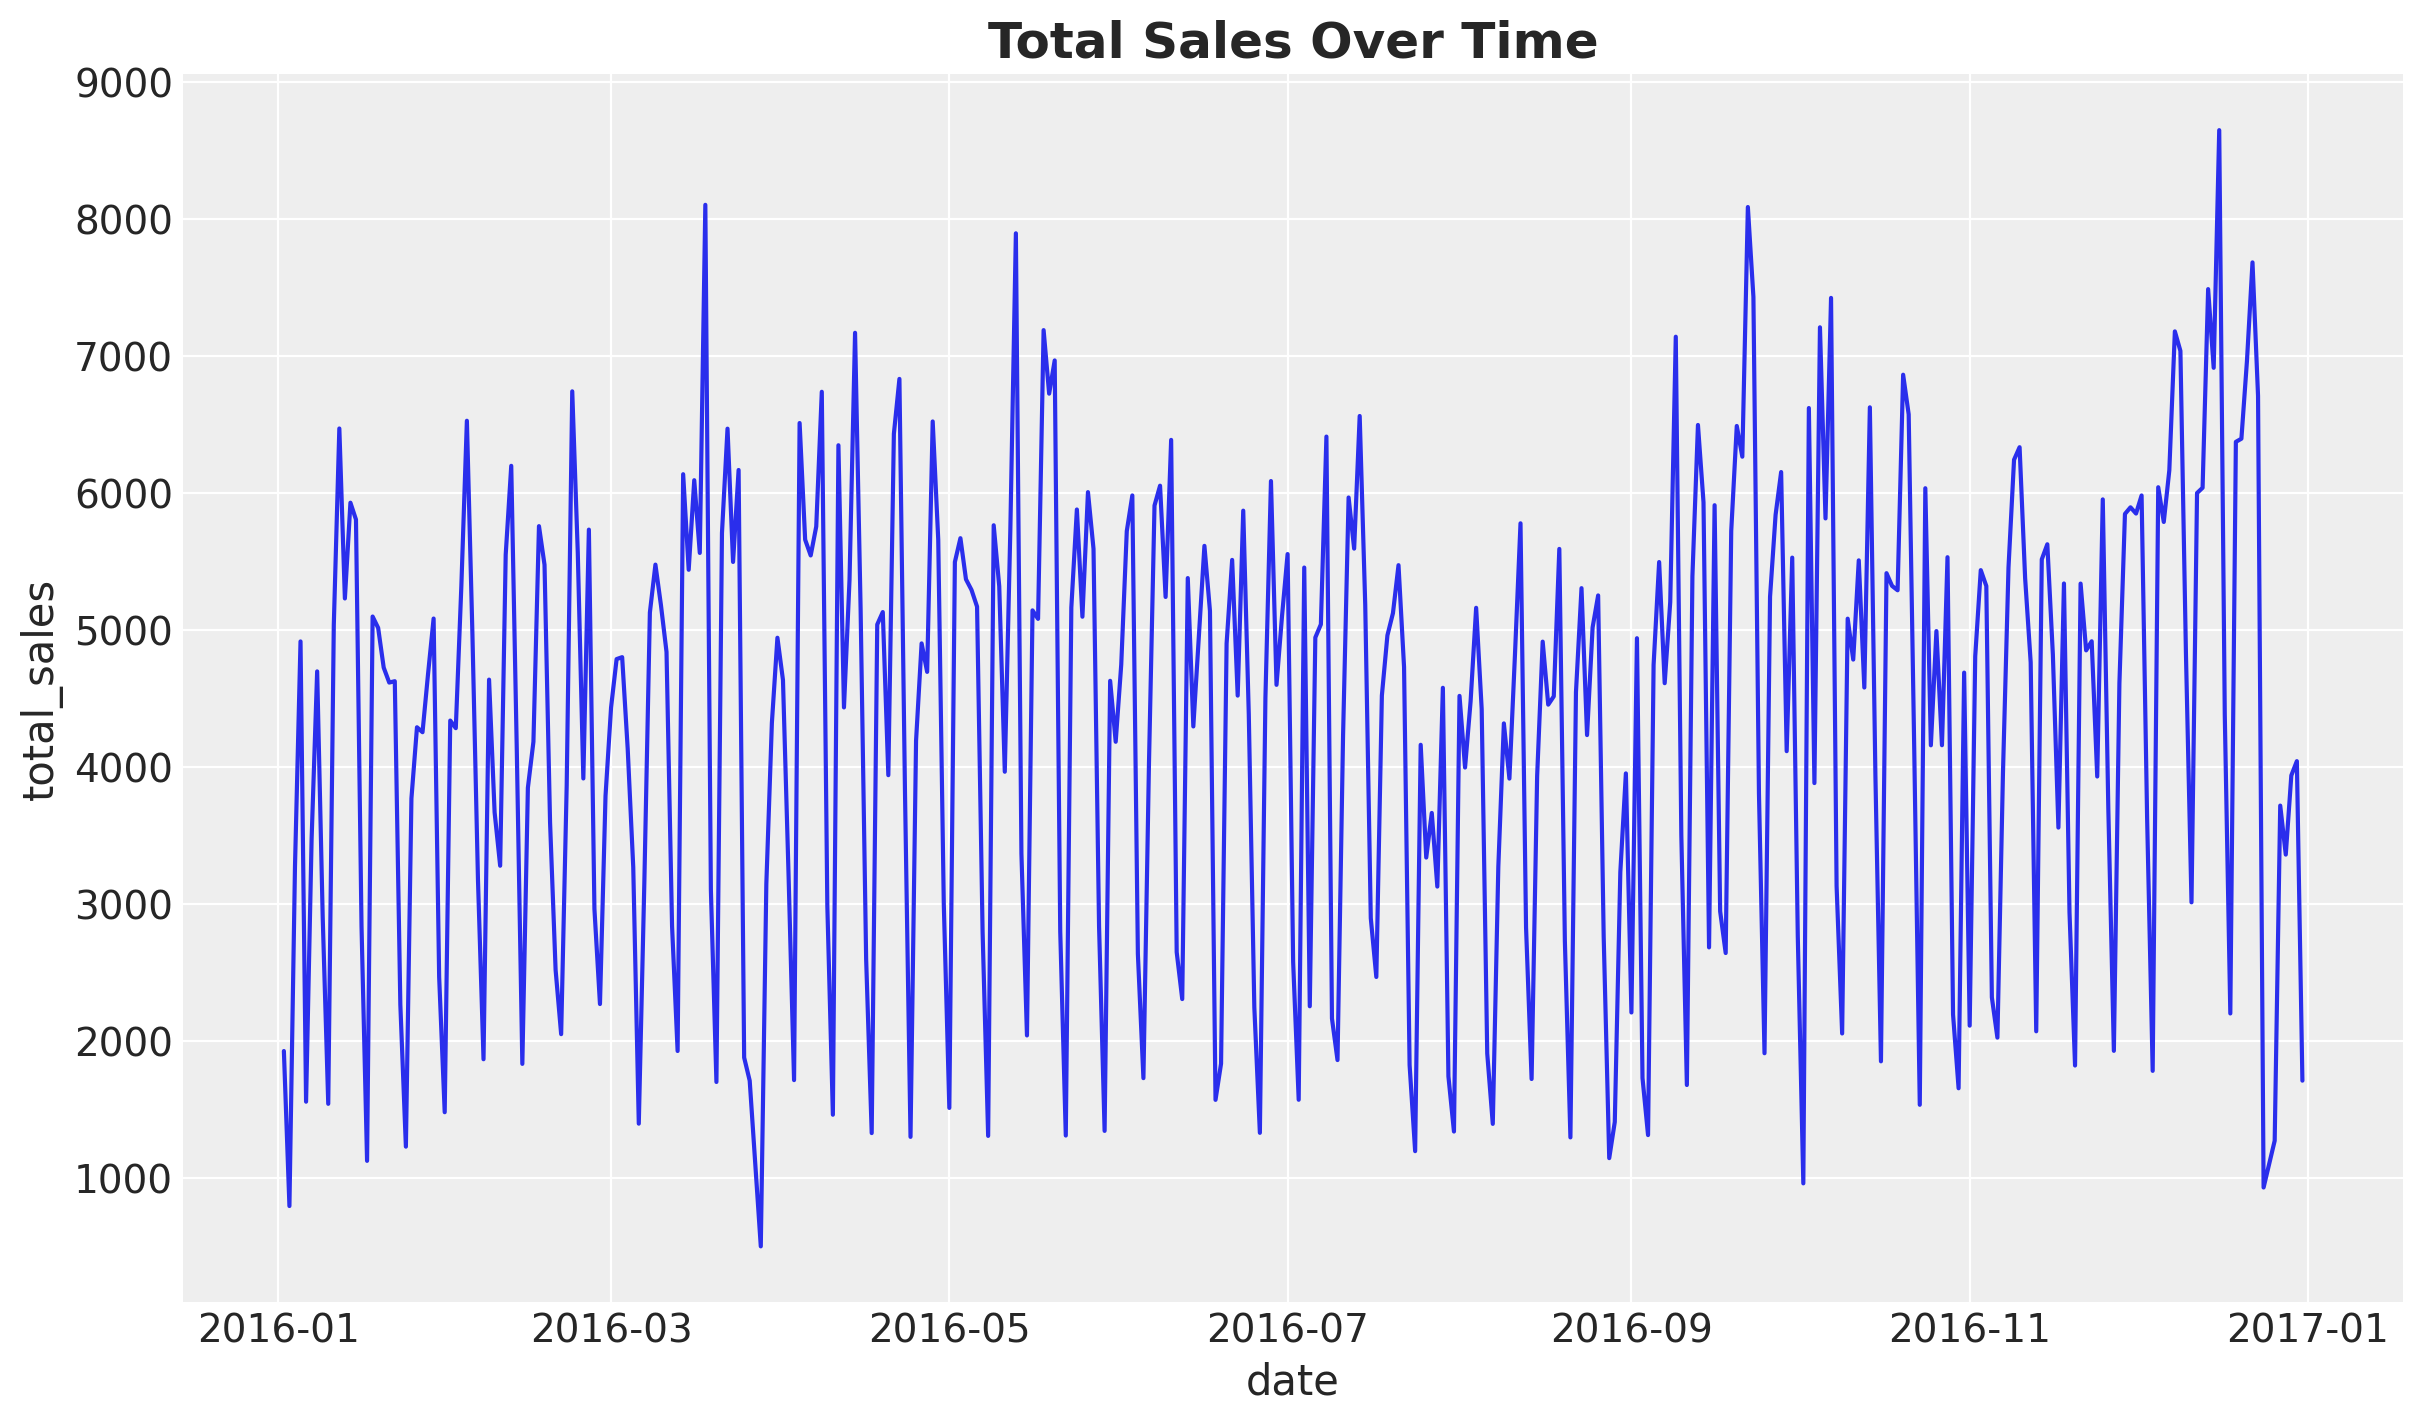

In [6]:
fig, ax = plt.subplots()
sns.lineplot(
    data=data_df.group_by("date").agg(
        pl.col("sales_amount").sum().alias("total_sales")
    ),
    x="date",
    y="total_sales",
    ax=ax,
)
ax.set_title("Total Sales Over Time", fontsize=18, fontweight="bold");

We confirm we have one year of data with a clear weekly seasonal pattern. There is no clear trend in the data.

Finally, we plot the distribution of the sales amount (in the log scale).

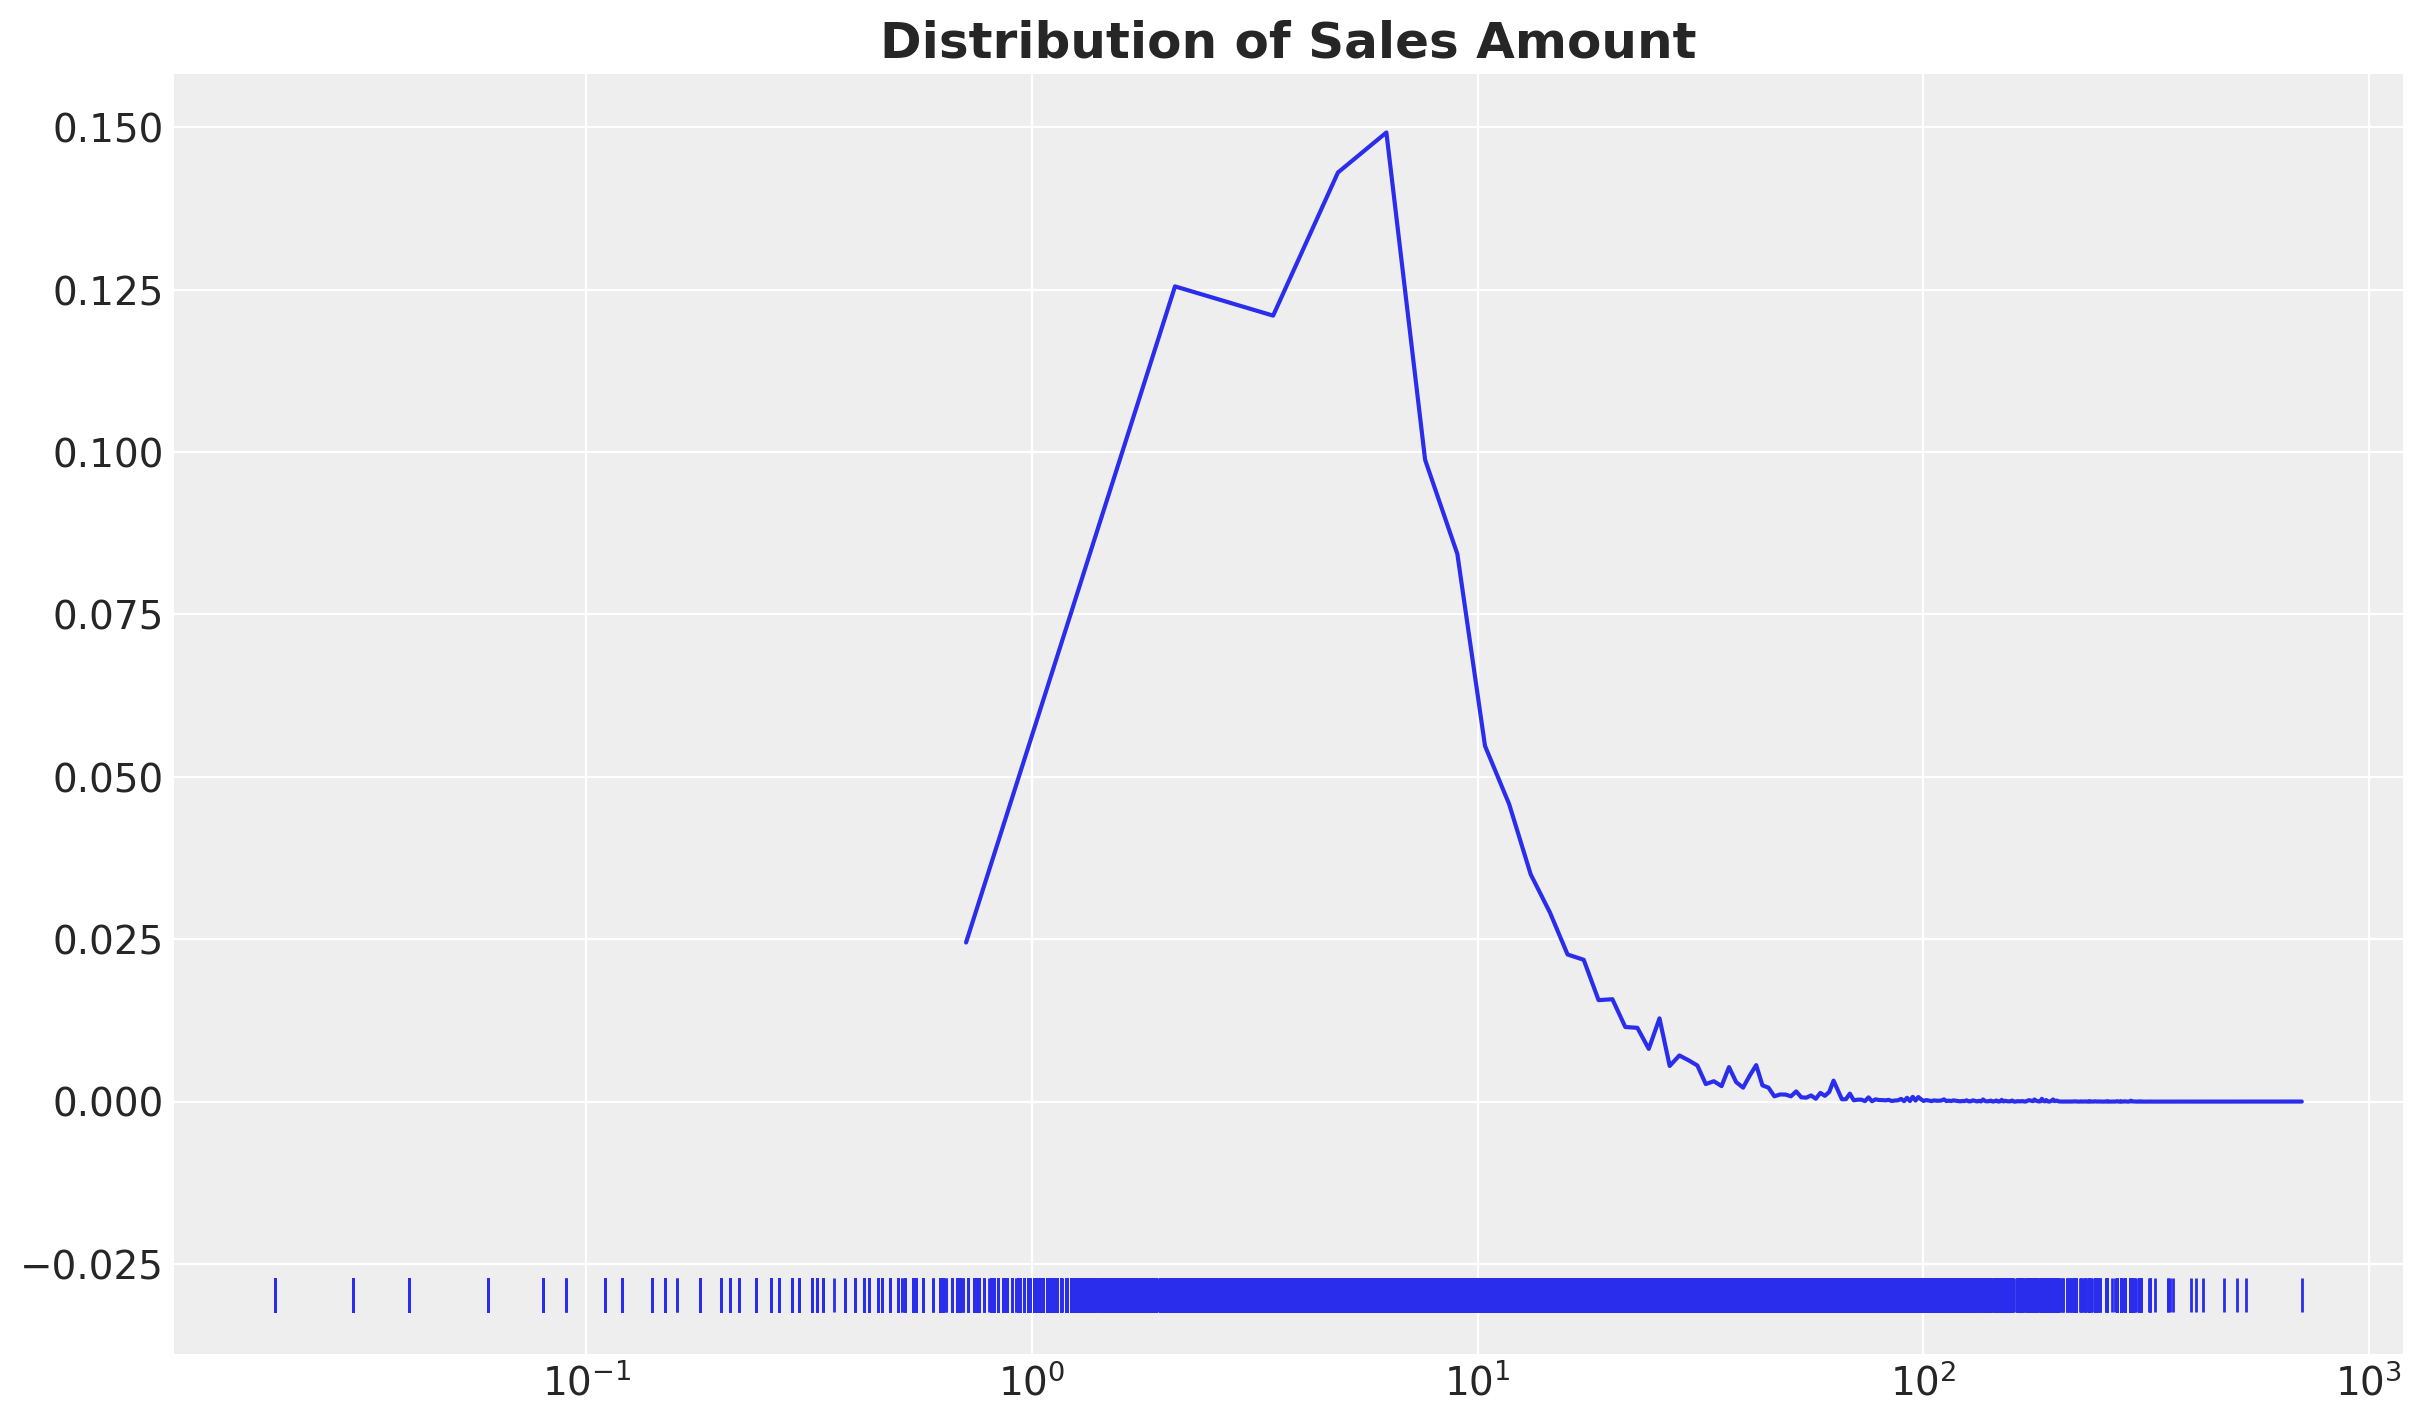

In [7]:
fig, ax = plt.subplots()
az.plot_dist(data_df["sales_amount"], rug=True, ax=ax)
ax.set(xscale="log")
ax.set_title("Distribution of Sales Amount", fontsize=18, fontweight="bold");

The values per transaction are not very large and are typically in the range from $1$ to $10$.

## Data Preparation 

Now we prepare the data for the model. In this example we will use a constant elasticity price response model of the form

$$
q(p) = Ap^{b}
$$

where $q$ is the quantity sold and $p$ is the price. We can linearize the model by taking the log of both sides.

$$
\log(q) = \log(A) + b \log(p)
$$

and verify that the elasticity is given by

$$
\text{elasticity} = \frac{d \log(q)}{d \log(p)} = b
$$

For the first model we fit a naive model where we assume that each SKU has its own intercept and slope. For this purposes we need to filter out SKUs with wither very little data or very little price variation.

In [8]:
# Filter SKUs with very little data or very little price variation
n_dates_expr = pl.col("date").n_unique().over("sku").alias("n_dates")
n_prices_expr = pl.col("price").n_unique().over("sku").alias("n_prices")

n_dates_threshold = 10
n_prices_threshold = 10

n_dates_filter = n_dates_expr > n_dates_threshold
n_prices_filter = n_prices_expr > n_prices_threshold

# Compute log price and log quantity
log_price_expr = pl.col("price").log().alias("log_price")
log_quantity_expr = pl.col("quantity").log().alias("log_quantity")


model_df = (
    data_df.with_columns(log_price_expr, log_quantity_expr)
    .filter(n_dates_filter & n_prices_filter)
    .sort(by=["sku_category", "sku", "date"])
)

model_df.head()

date,sku_category,sku,quantity,sales_amount,price,log_price,log_quantity
date,str,str,f64,f64,f64,f64,f64
2016-01-02,"""0H2""","""ABFD7""",1.0,4.84,4.84,1.576915,0.0
2016-01-04,"""0H2""","""ABFD7""",1.0,4.84,4.84,1.576915,0.0
2016-01-04,"""0H2""","""ABFD7""",1.0,4.84,4.84,1.576915,0.0
2016-01-04,"""0H2""","""ABFD7""",1.0,4.84,4.84,1.576915,0.0
2016-01-05,"""0H2""","""ABFD7""",1.0,4.84,4.84,1.576915,0.0


Let's count the number of SKUs and SKUs categories after filtering.

In [9]:
print(f"Number of SKUs: {model_df['sku'].n_unique()}")
print(f"Number of SKUs Categories: {model_df['sku_category'].n_unique()}")

Number of SKUs: 87
Number of SKUs Categories: 33


Next, we encode our relevant variables. We won't use them all in the first model but we prepare them for other models (this is very similar to the encoding from the example notebook [Hierarchical Exponential Smoothing Model](https://juanitorduz.github.io/hierarchical_exponential_smoothing/)).

In [10]:
obs_idx = np.arange(model_df.shape[0])

sku_encoder = LabelEncoder()
sku_idx = jnp.array(sku_encoder.fit_transform(model_df["sku"]))
sku = sku_encoder.classes_

sku_category_encoder = LabelEncoder()
sku_category_idx = jnp.array(
    sku_category_encoder.fit_transform(model_df["sku_category"])
)
sku_category = sku_category_encoder.classes_

date_encoder = LabelEncoder()
date_idx = jnp.array(
    date_encoder.fit_transform(
        model_df.select(pl.col("date").dt.strftime("%Y-%m-%d"))["date"]
    )
)
date = date_encoder.classes_

log_price = model_df["log_price"].to_jax()
log_quantity = model_df["log_quantity"].to_jax()

sku_category_mapping_df = (
    model_df.select(["sku", "sku_category"]).unique().sort(["sku", "sku_category"])
)

sku_category_mapping_df = sku_category_mapping_df.with_columns(
    sku_idx=sku_encoder.transform(sku_category_mapping_df["sku"]),
    sku_category_idx=sku_category_encoder.transform(
        sku_category_mapping_df["sku_category"]
    ),
).sort("sku_idx")

sku_category_mapping = sku_category_mapping_df["sku_category_idx"].to_jax()

## Simple Elasticity Model

The first model we fit is a simple model where each SKU has its own intercept and slope.

In [11]:
def simple_elasticity_model(log_price, sku_idx, log_quantity=None):
    n_obs = log_price.size
    n_sku = np.unique(sku_idx).size

    with numpyro.plate("sku", n_sku):
        sku_intercept = numpyro.sample("sku_intercept", dist.Normal(loc=0, scale=1))
        beta_log_price = numpyro.sample("beta_log_price", dist.Normal(loc=0, scale=1))
        sigma_sku = numpyro.sample("sigma", dist.HalfNormal(scale=1))

    mu = beta_log_price[sku_idx] * log_price + sku_intercept[sku_idx]

    sigma = sigma_sku[sku_idx]

    with numpyro.plate("data", n_obs):
        numpyro.sample("obs", dist.Normal(loc=mu, scale=sigma), obs=log_quantity)

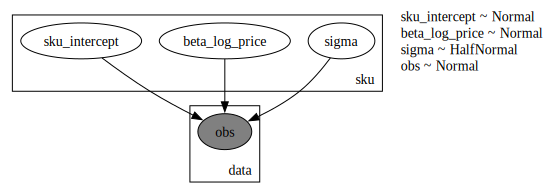

In [12]:
numpyro.render_model(
    model=simple_elasticity_model,
    model_kwargs={
        "log_price": log_price,
        "sku_idx": sku_idx,
        "log_quantity": log_quantity,
    },
    render_distributions=True,
    render_params=True,
)

We fir the model using stochastic variational inference.

100%|██████████| 25000/25000 [00:08<00:00, 2835.41it/s, init loss: 304577.6562, avg. loss [23751-25000]: -1819.7923]


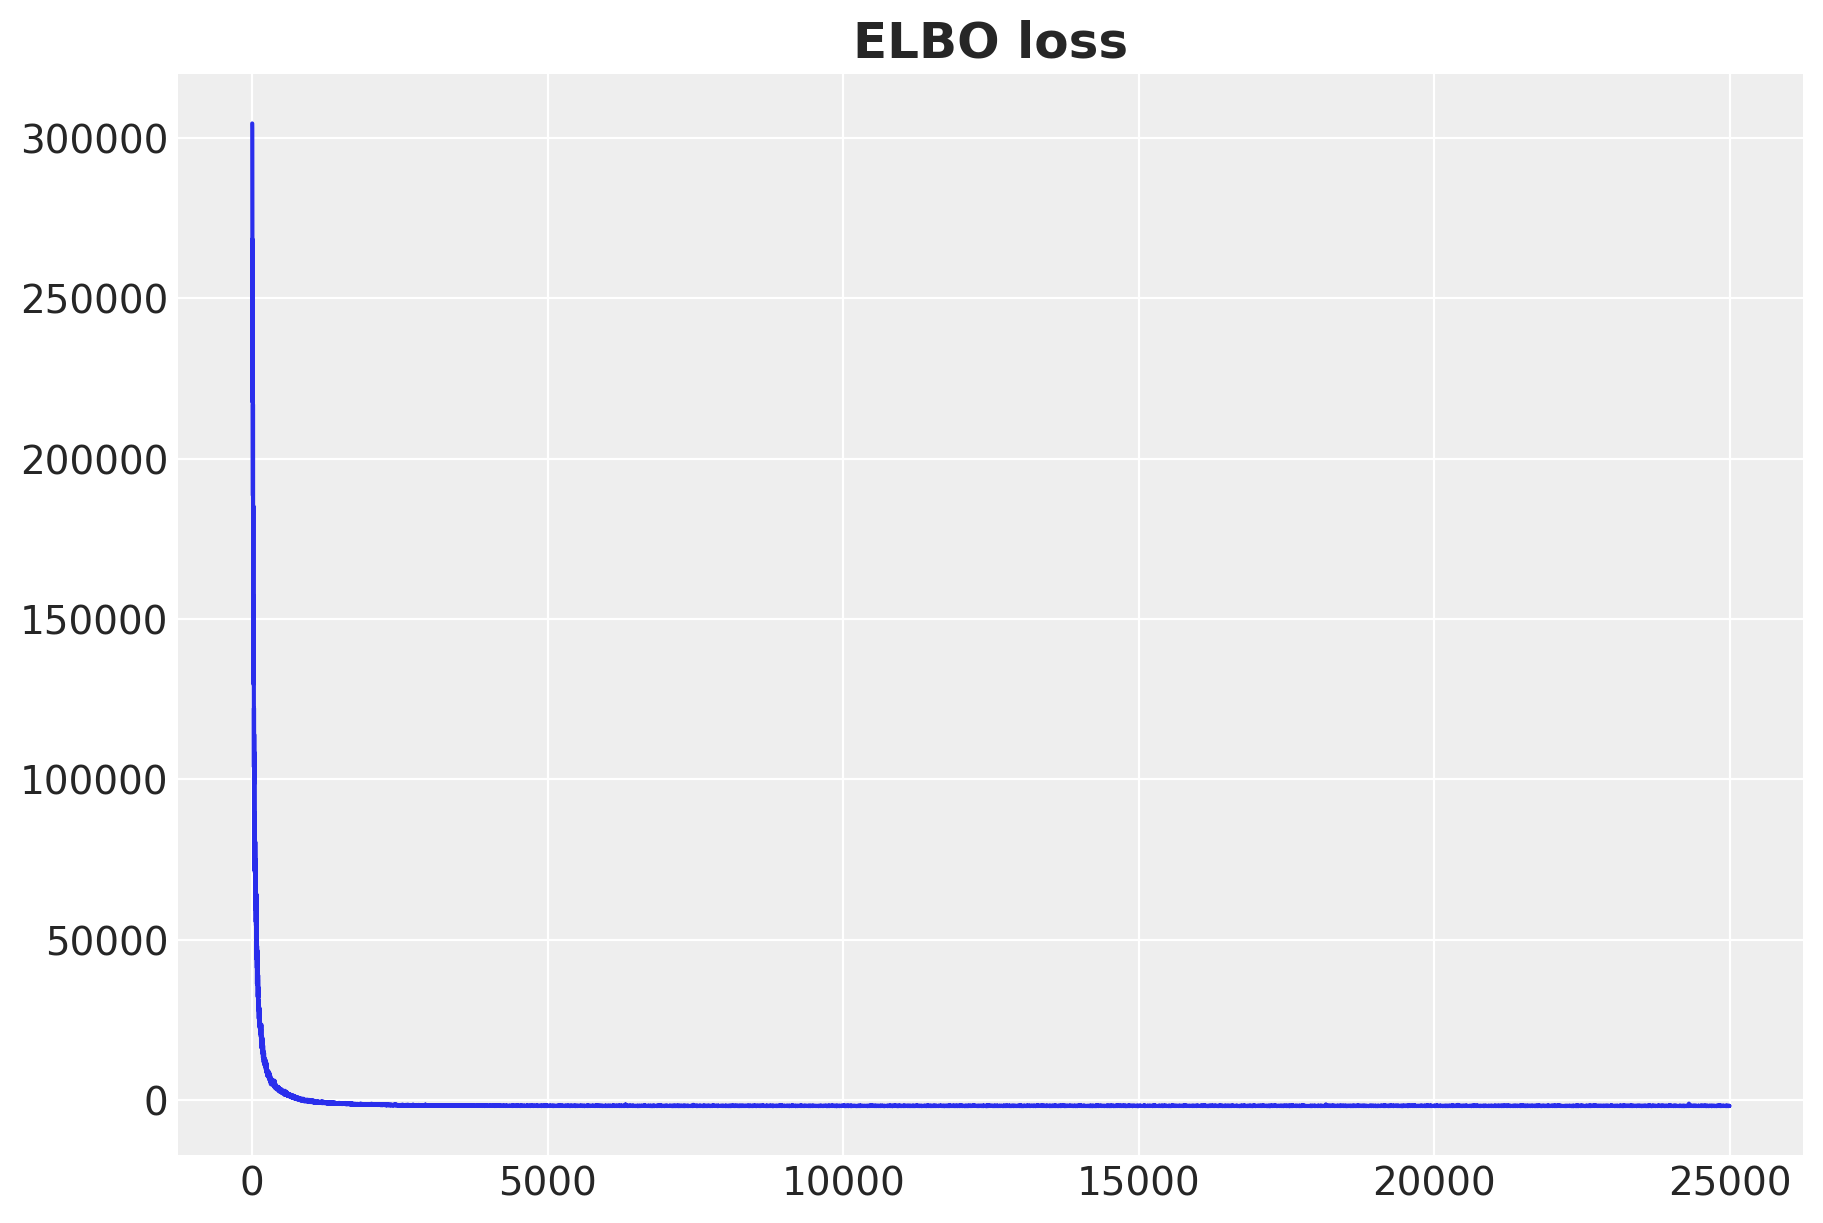

In [13]:
simple_guide = AutoNormal(simple_elasticity_model)
simple_optimizer = numpyro.optim.Adam(step_size=0.01)

simple_svi = SVI(
    simple_elasticity_model,
    simple_guide,
    simple_optimizer,
    loss=Trace_ELBO(),
)

num_steps = 25_000

rng_key, rng_subkey = random.split(key=rng_key)
simple_svi_result = simple_svi.run(
    rng_subkey,
    num_steps,
    log_price,
    sku_idx,
    log_quantity,
)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(simple_svi_result.losses)
ax.set_title("ELBO loss", fontsize=18, fontweight="bold");

We can visualize the posterior distribution of the elasticity estimates.

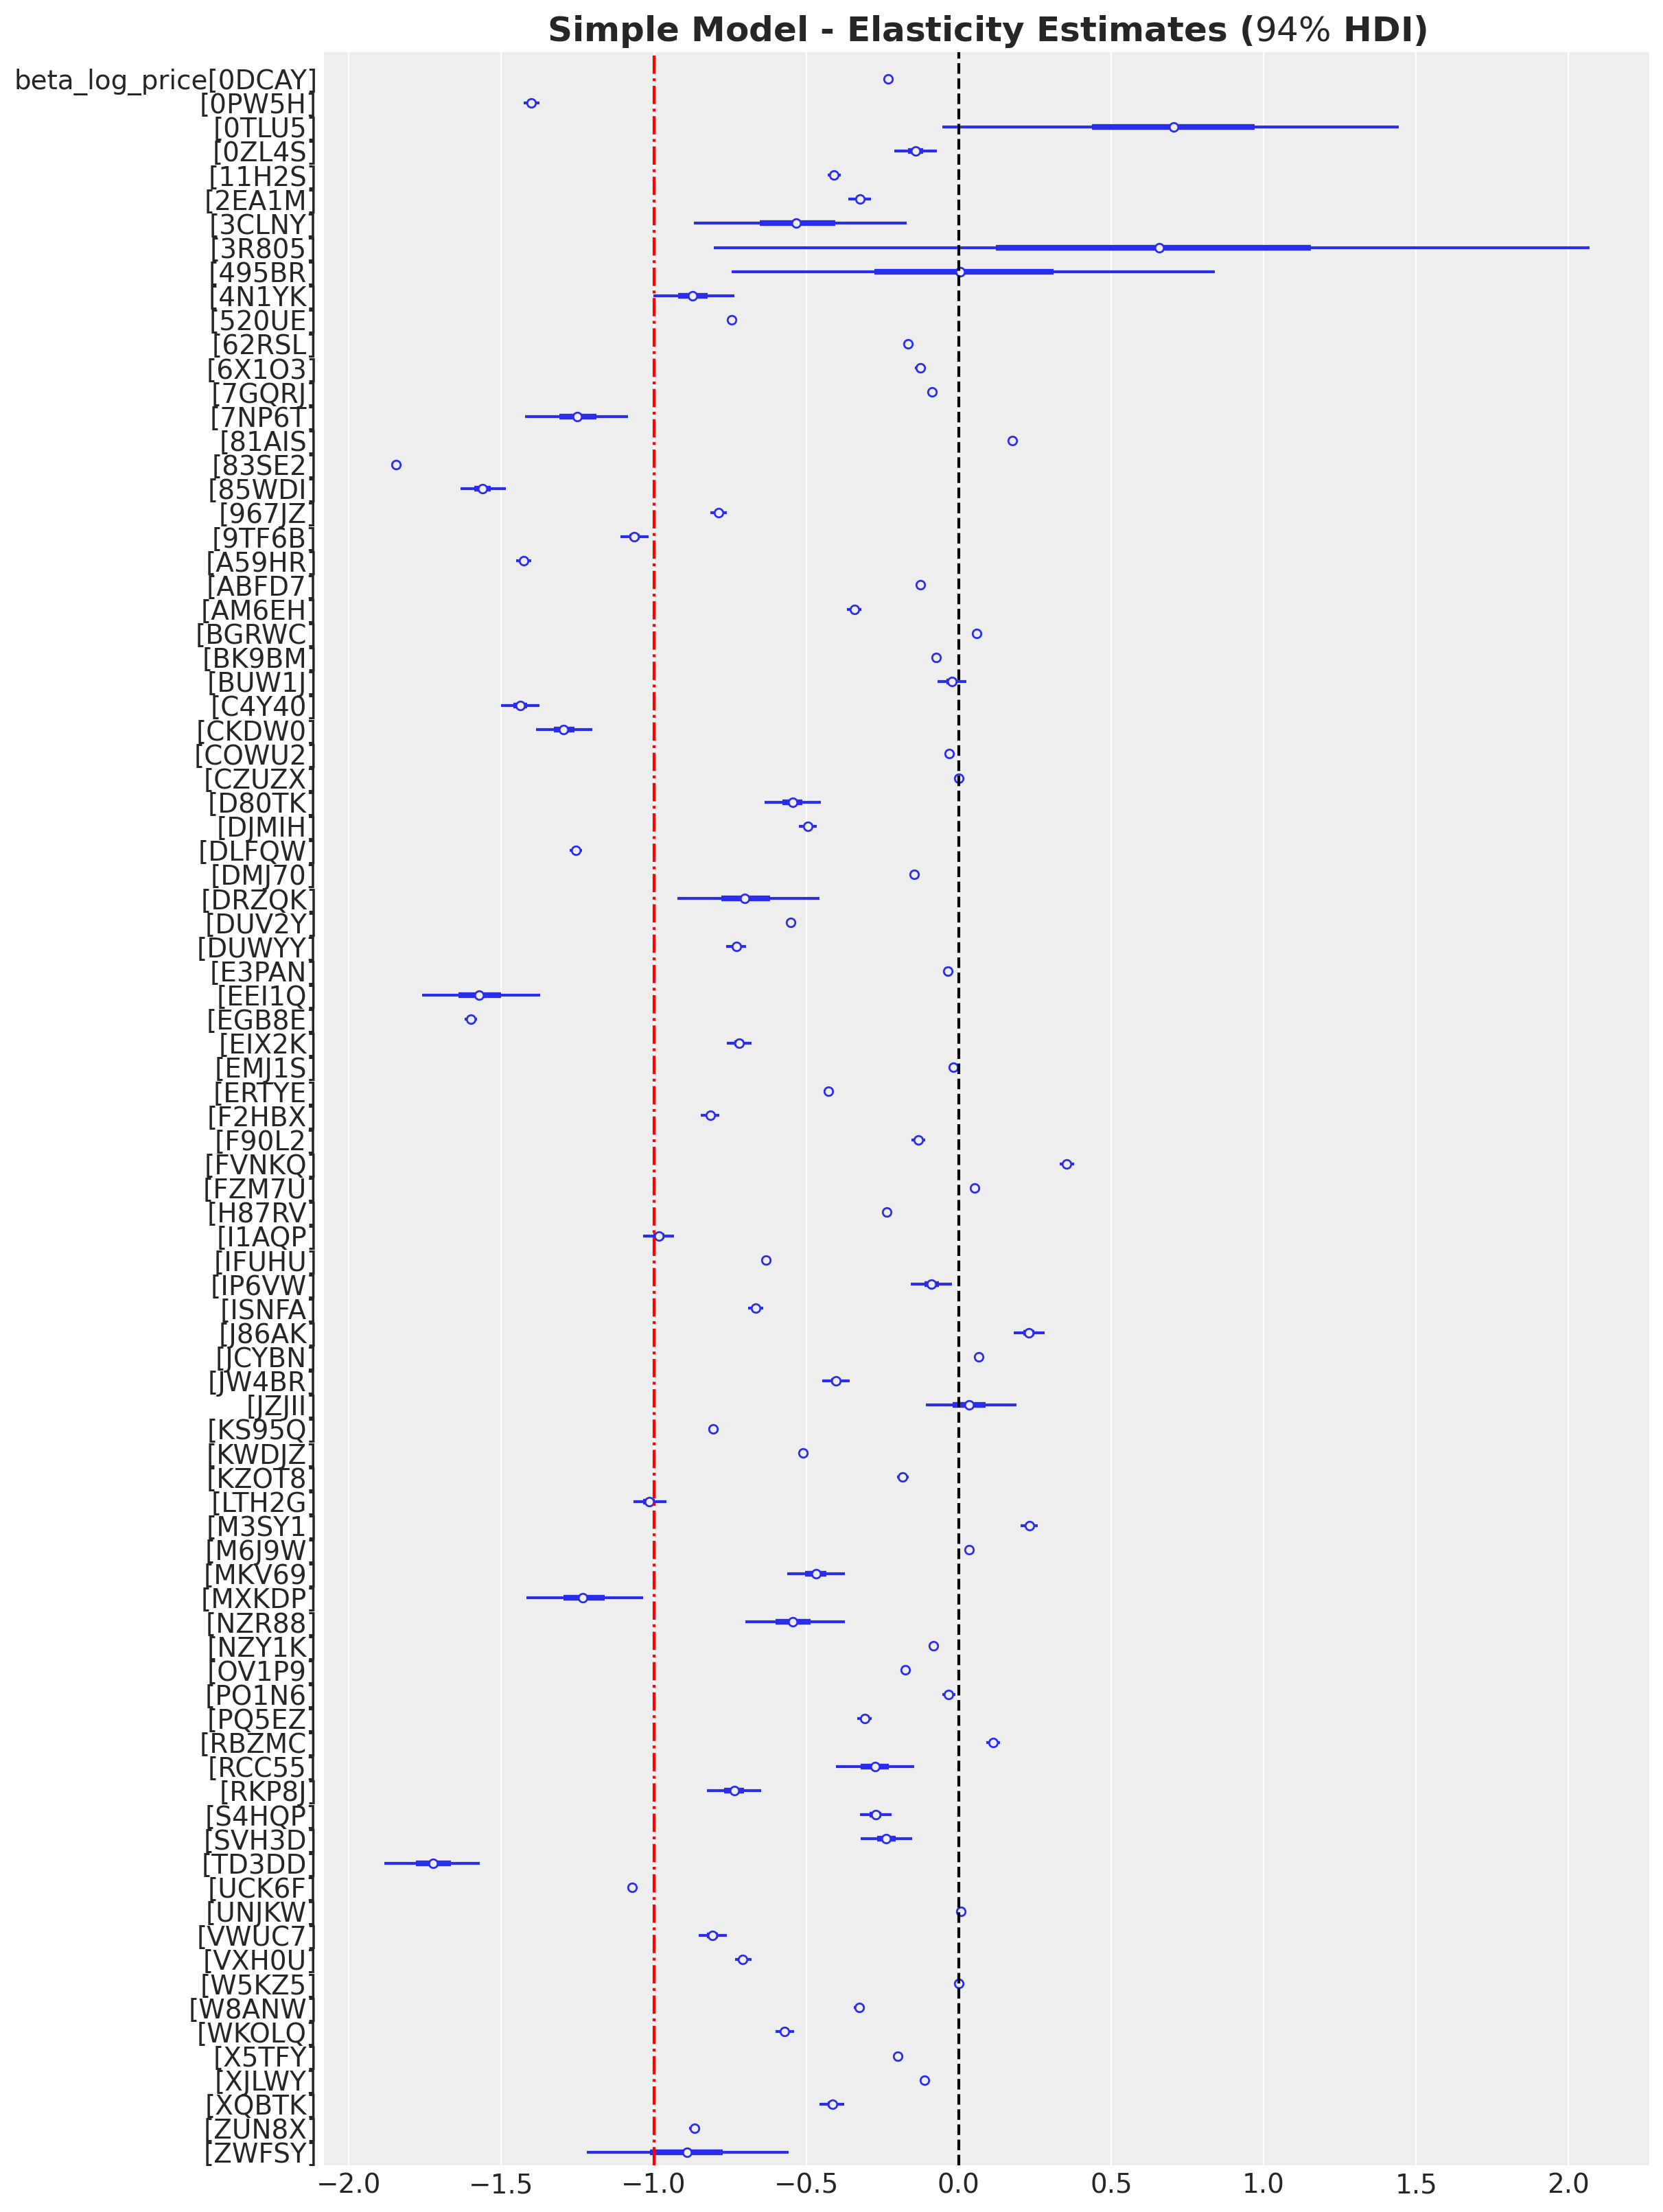

In [14]:
rng_key, rng_subkey = random.split(rng_key)
simple_svi_posterior = Predictive(
    model=simple_elasticity_model,
    guide=simple_guide,
    params=simple_svi_result.params,
    num_samples=5_000,
    return_sites=[
        "beta_log_price",
        "sigma",
        "obs",
    ],
)(rng_subkey, log_price, sku_idx, log_quantity)

simple_svi_idata = az.from_dict(
    posterior={
        k: jnp.expand_dims(a=jnp.asarray(v), axis=0)
        for k, v in simple_svi_posterior.items()
    },
    coords={"sku": sku, "obs_idx": obs_idx},
    dims={
        "beta_log_price": ["sku"],
        "sigma": ["sku"],
        "obs": ["obs_idx"],
    },
)

fig, ax = plt.subplots(figsize=(12, 16))
az.plot_forest(
    data=simple_svi_idata,
    var_names=["beta_log_price"],
    combined=True,
    ax=ax,
)
ax.axvline(x=0, color="black", linestyle="--")
ax.axvline(x=-1, color="red", linestyle="-.")
ax.set_title(
    r"Simple Model - Elasticity Estimates ($94\%$ HDI)", fontsize=18, fontweight="bold"
);

We would expect the elasticity to be negative from microeconomic theory.However, we see that some SKUs have a positive elasticity. This could be due to **endogeneity** in the data. For example, SKUs characteristics and seasonality are likely correlated with the price and quantity sold creating a backdoor path from price to quantity.

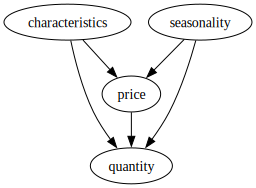

In [15]:
g = gr.Digraph()
g.edge("price", "quantity")
g.edge("characteristics", "quantity")
g.edge("characteristics", "price")
g.edge("seasonality", "quantity")
g.edge("seasonality", "price")
g

This motivates the next model where we add fixed effects for SKUs and dates.

**Remark:** The red dashed line in the elasticity plot at $-1$ is the threshold between inelastic and elastic SKUs.

**Remark:** Observe that some SKUs with a positive elasticity have very large credibility intervals. Hence, this could be simply due to the small amount of data. We could have imposed a more restrictive prior to enforce negative elasticities (e.g. a half-normal). This is a similar approach as priors for media channels in a media-mix-model, see for example the notebook [Media Mix Model and Experimental Calibration: A Simulation Study](https://juanitorduz.github.io/mmm_roas/).

## Fixed Effects Model

We extend the simple model above by including dummy variables for each SKU and dates.

In [16]:
def fixed_effects_elasticity_model(log_price, sku_idx, date_idx, log_quantity=None):
    n_obs = log_price.size
    n_sku = np.unique(sku_idx).size
    n_date = np.unique(date_idx).size

    with numpyro.plate("sku", n_sku):
        sku_intercept = numpyro.sample("sku_intercept", dist.Normal(loc=0, scale=1))
        beta_log_price = numpyro.sample("beta_log_price", dist.Normal(loc=0, scale=1))
        sigma_sku = numpyro.sample("sigma", dist.HalfNormal(scale=5))

    with numpyro.plate("date", n_date):
        date_intercept = numpyro.sample("date_intercept", dist.Normal(loc=0, scale=1))

    mu = (
        beta_log_price[sku_idx] * log_price
        + sku_intercept[sku_idx]
        + date_intercept[date_idx]
    )

    sigma = sigma_sku[sku_idx]

    with numpyro.plate("data", n_obs):
        numpyro.sample("obs", dist.Normal(loc=mu, scale=sigma), obs=log_quantity)

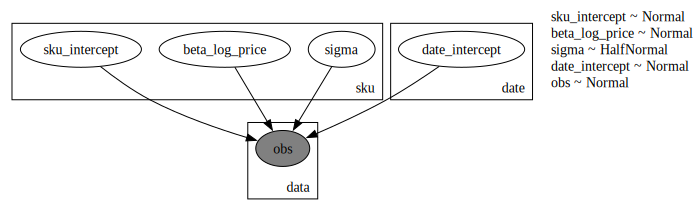

In [17]:
numpyro.render_model(
    model=fixed_effects_elasticity_model,
    model_kwargs={
        "log_price": log_price,
        "sku_idx": sku_idx,
        "date_idx": date_idx,
        "log_quantity": log_quantity,
    },
    render_distributions=True,
    render_params=True,
)

The fitting process is the same as before.

100%|██████████| 25000/25000 [00:10<00:00, 2301.62it/s, init loss: 356744.6562, avg. loss [23751-25000]: -506.9645]


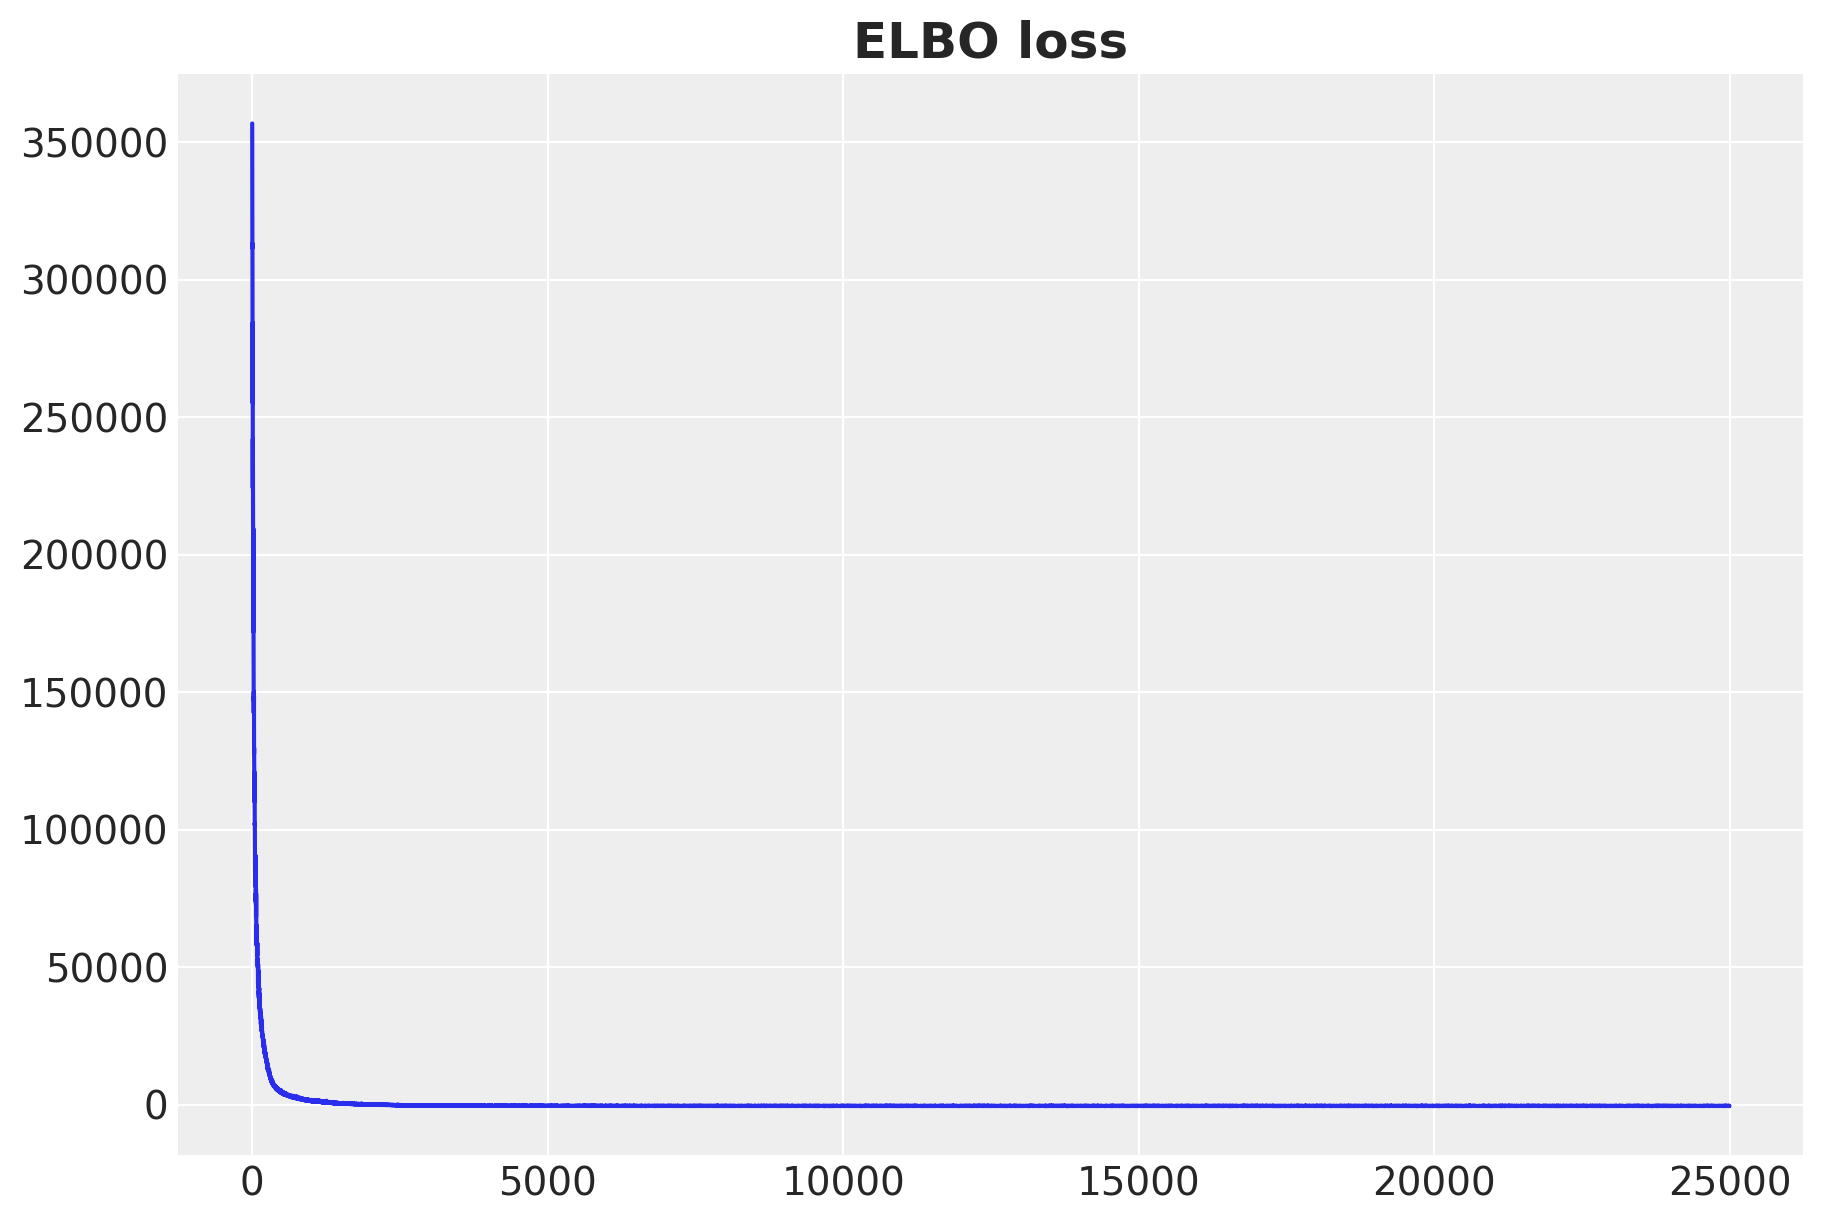

In [18]:
fixed_effects_guide = AutoNormal(fixed_effects_elasticity_model)
fixed_effects_optimizer = numpyro.optim.Adam(step_size=0.01)

fixed_effects_svi = SVI(
    fixed_effects_elasticity_model,
    fixed_effects_guide,
    fixed_effects_optimizer,
    loss=Trace_ELBO(),
)

num_steps = 25_000

rng_key, rng_subkey = random.split(key=rng_key)
fixed_effects_svi_result = fixed_effects_svi.run(
    rng_subkey,
    num_steps,
    log_price,
    sku_idx,
    date_idx,
    log_quantity,
)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(fixed_effects_svi_result.losses)
ax.set_title("ELBO loss", fontsize=18, fontweight="bold");

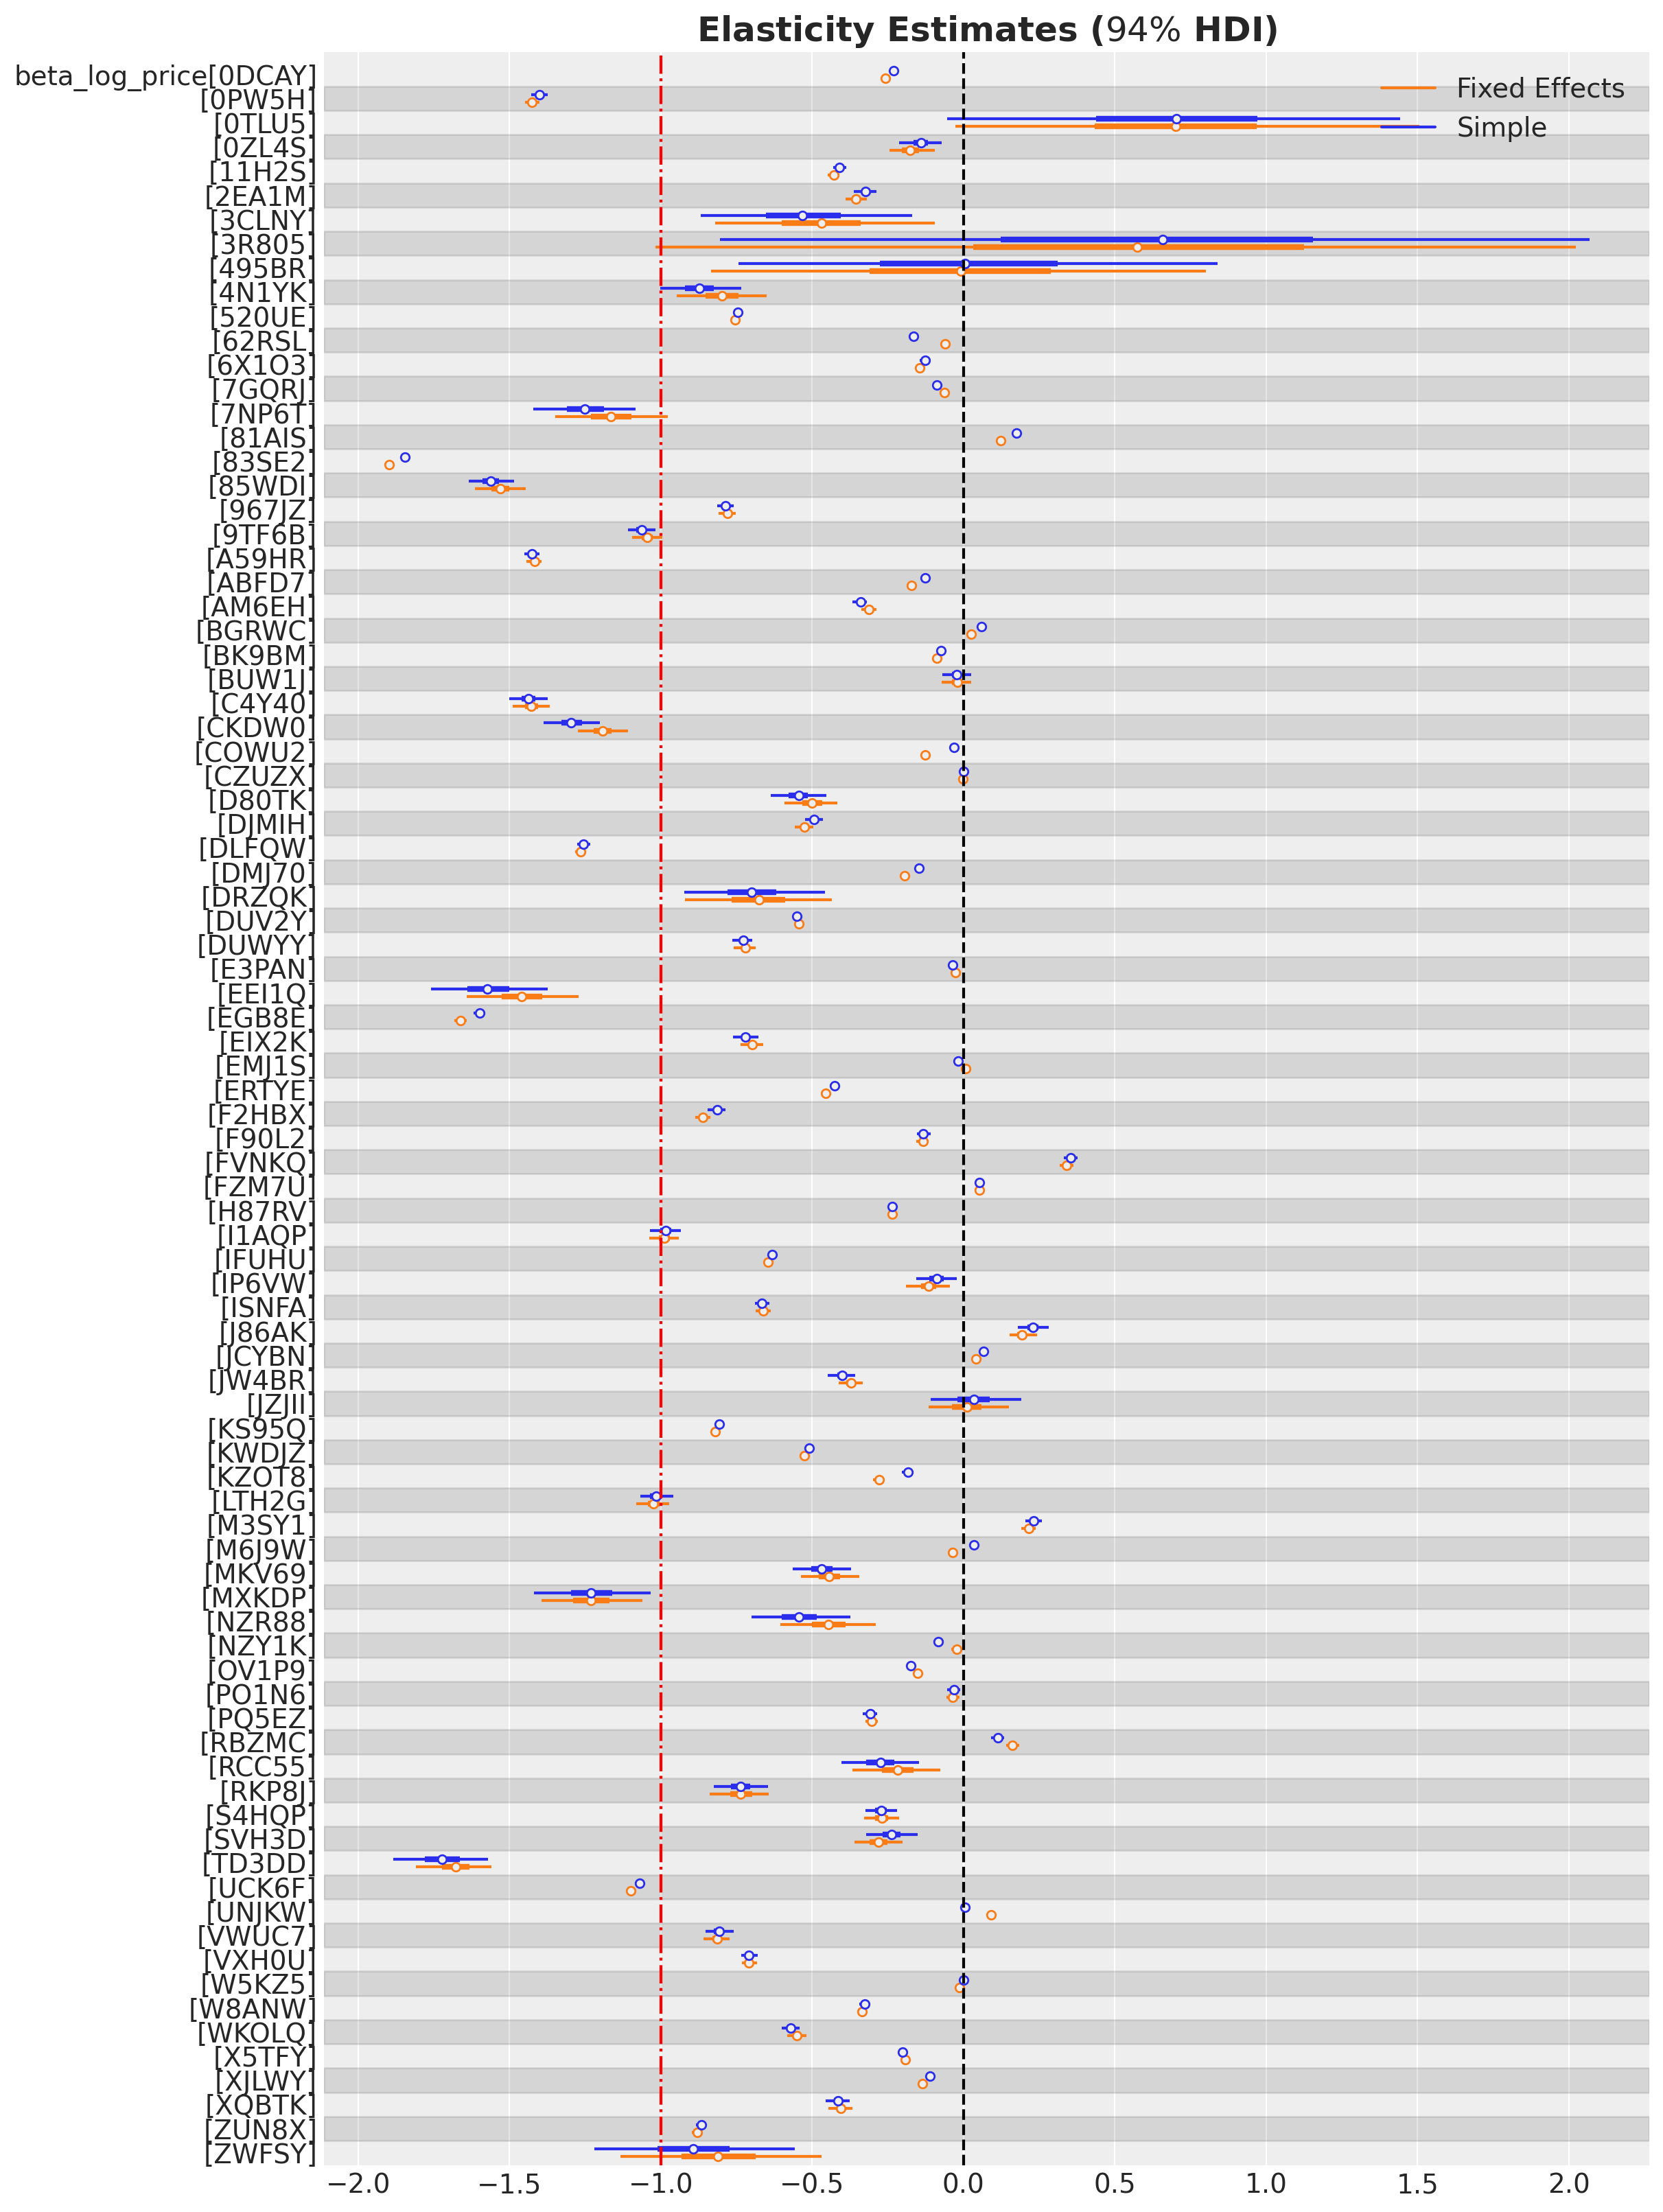

In [19]:
rng_key, rng_subkey = random.split(rng_key)
fixed_effects_svi_posterior = Predictive(
    model=fixed_effects_elasticity_model,
    guide=fixed_effects_guide,
    params=fixed_effects_svi_result.params,
    num_samples=5_000,
    return_sites=["beta_log_price"],
)(rng_subkey, log_price, sku_idx, date_idx, log_quantity)

fixed_effects_svi_idata = az.from_dict(
    posterior={
        k: jnp.expand_dims(a=jnp.asarray(v), axis=0)
        for k, v in fixed_effects_svi_posterior.items()
    },
    coords={"sku": sku, "obs_idx": obs_idx},
    dims={
        "beta_log_price": ["sku"],
        "sigma": ["sku"],
        "obs": ["obs_idx"],
    },
)

fig, ax = plt.subplots(figsize=(12, 16))
az.plot_forest(
    data=[simple_svi_idata, fixed_effects_svi_idata],
    model_names=["Simple", "Fixed Effects"],
    var_names=["beta_log_price"],
    combined=True,
    ax=ax,
)
ax.axvline(x=0, color="black", linestyle="--")
ax.axvline(x=-1, color="red", linestyle="-.")
ax.set_title(
    r"Elasticity Estimates ($94\%$ HDI)",
    fontsize=18,
    fontweight="bold",
);

The fixed effects model seems very similar to the first simple model. Next, we consider a more complex model with a richer structure.

## Hierarchical Model

As adding fixed effects for SKUs and dates is not enough, we consider a hierarchical model to try to improve the estimates. Concretely, in addition to the SKU and date fixed effects, we include a hierarchical structure in the SKU Category to regularize the elasticity estimates at the lowest level (SKU ID). In addition, the noise of the estimation is also included in the hierarchical structure.

In [20]:
def hierarchical_elasticity_model(
    log_price,
    sku_idx,
    date_idx,
    sku_category_idx,
    sku_category_mapping,
    log_quantity=None,
    subsample_size=None,
):
    n_obs = log_price.size
    n_sku = np.unique(sku_idx).size
    n_sku_category = np.unique(sku_category_idx).size
    n_date = np.unique(date_idx).size

    beta_log_price_loc_loc = numpyro.sample(
        "beta_log_price_loc_loc", dist.Normal(loc=0, scale=1)
    )
    beta_log_price_loc_scale = numpyro.sample(
        "beta_log_price_loc_scale", dist.HalfNormal(scale=1)
    )

    beta_log_price_scale_scale = numpyro.sample(
        "beta_log_price_scale_scale", dist.HalfNormal(scale=1)
    )

    sigma_global = numpyro.sample("sigma_global", dist.HalfNormal(scale=1))

    with numpyro.plate("sku_category", n_sku_category):
        beta_log_price_loc = numpyro.sample(
            "beta_log_price_loc",
            dist.Normal(loc=beta_log_price_loc_loc, scale=beta_log_price_loc_scale),
        )
        beta_log_price_scale = numpyro.sample(
            "beta_log_price_scale", dist.HalfNormal(scale=beta_log_price_scale_scale)
        )

        numpyro.sample(
            "beta_log_price_prior",
            dist.Normal(loc=beta_log_price_loc, scale=beta_log_price_scale),
        )

        sigma_sku_category = numpyro.sample(
            "sigma_sku_category", dist.HalfNormal(scale=sigma_global)
        )

    with numpyro.plate("sku", n_sku):
        sku_intercept = numpyro.sample("sku_intercept", dist.Normal(loc=0, scale=1))
        beta_log_price = numpyro.sample(
            "beta_log_price",
            dist.Normal(
                loc=beta_log_price_loc[sku_category_mapping],
                scale=beta_log_price_scale[sku_category_mapping],
            ),
        )

    with numpyro.plate("date", n_date):
        date_intercept = numpyro.sample("date_intercept", dist.Normal(loc=0, scale=1))

    mu = (
        beta_log_price[sku_idx] * log_price
        + sku_intercept[sku_idx]
        + date_intercept[date_idx]
    )

    sigma = sigma_sku_category[sku_category_idx]

    with numpyro.plate("data", n_obs, subsample_size=subsample_size):
        numpyro.sample("obs", dist.Normal(loc=mu, scale=sigma), obs=log_quantity)

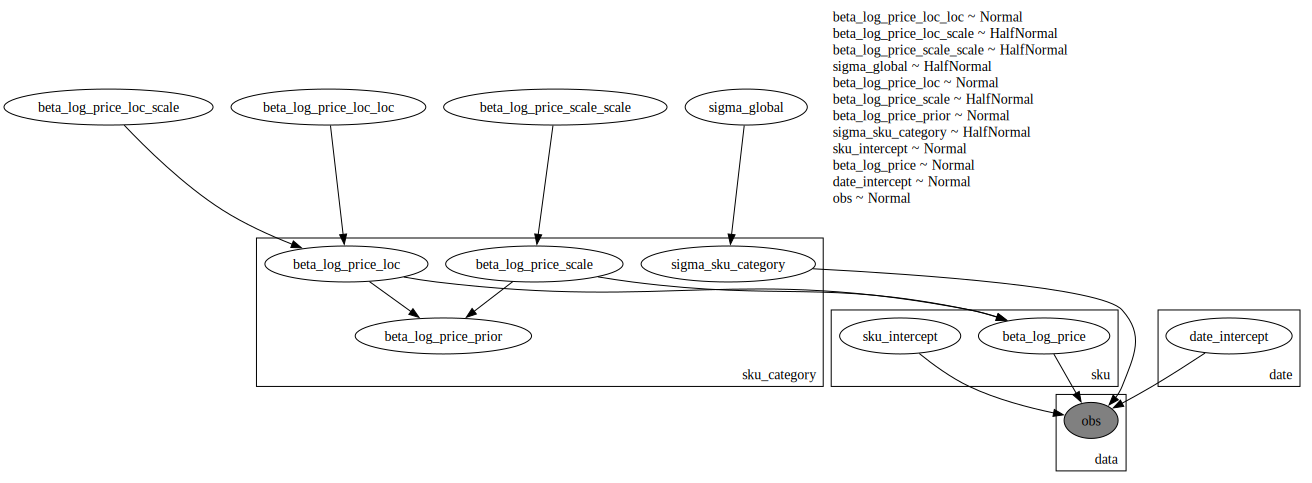

In [21]:
numpyro.render_model(
    model=hierarchical_elasticity_model,
    model_kwargs={
        "log_price": log_price,
        "sku_idx": sku_idx,
        "date_idx": date_idx,
        "sku_category_idx": sku_category_idx,
        "sku_category_mapping": sku_category_mapping,
        "log_quantity": log_quantity,
    },
    render_distributions=True,
    render_params=True,
)

As we typically do, we reparameterize the model to (try to) improve the sampling process.

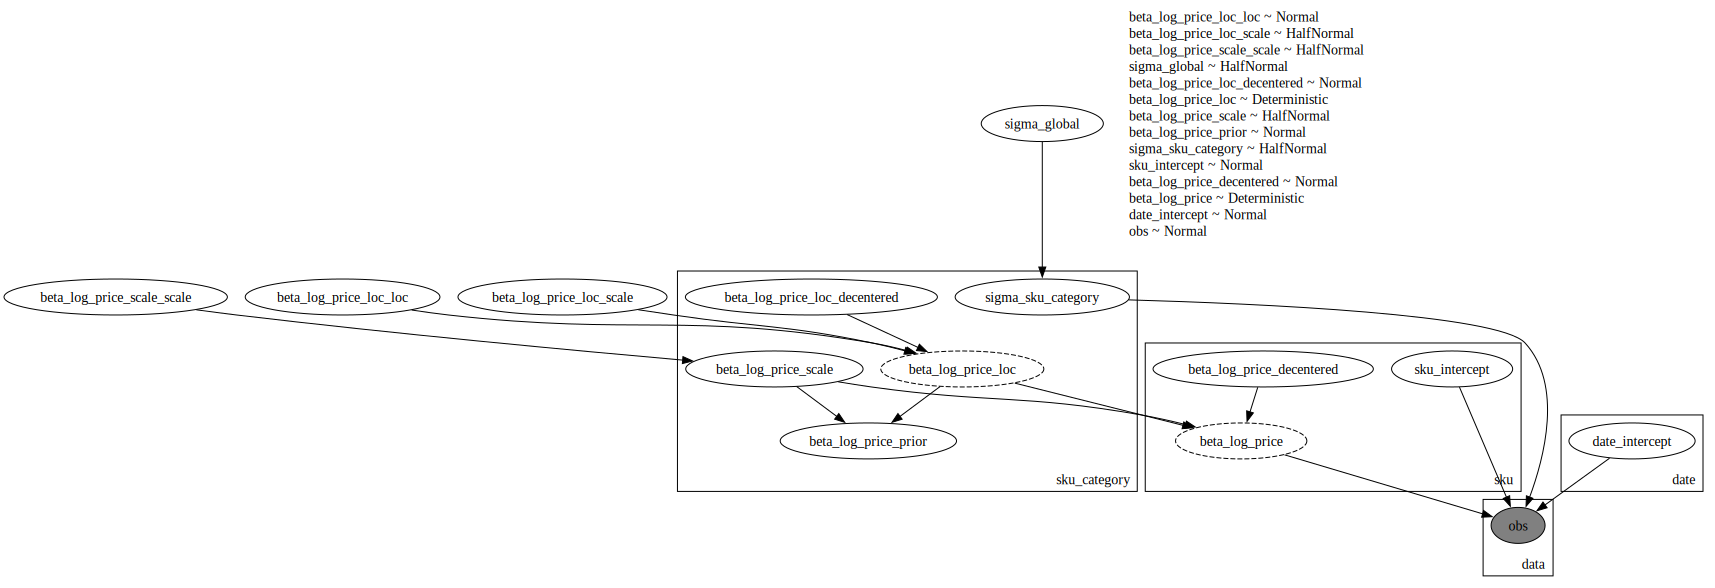

In [22]:
reparam_config = {
    "beta_log_price_loc": LocScaleReparam(0),
    "beta_log_price": LocScaleReparam(0),
}

reparam_hierarchical_elasticity_model = reparam(
    fn=hierarchical_elasticity_model, config=reparam_config
)

numpyro.render_model(
    model=reparam_hierarchical_elasticity_model,
    model_kwargs={
        "log_price": log_price,
        "sku_idx": sku_idx,
        "date_idx": date_idx,
        "sku_category_idx": sku_category_idx,
        "sku_category_mapping": sku_category_mapping,
        "log_quantity": log_quantity,
    },
    render_distributions=True,
    render_params=True,
)

Furthermore, we consider a more complex guide for the stochastic variational inference optimization. For the SKU category plate, we use a [`AutoMultivariateNormal`](https://num.pyro.ai/en/latest/autoguide.html#numpyro.infer.autoguide.AutoMultivariateNormal) guide. For the rest we keep the default [`AutoNormal`](https://num.pyro.ai/en/latest/autoguide.html#numpyro.infer.autoguide.AutoNormal) guide.

100%|██████████| 25000/25000 [00:21<00:00, 1146.46it/s, init loss: 7428603.0000, avg. loss [23751-25000]: 569.9154]


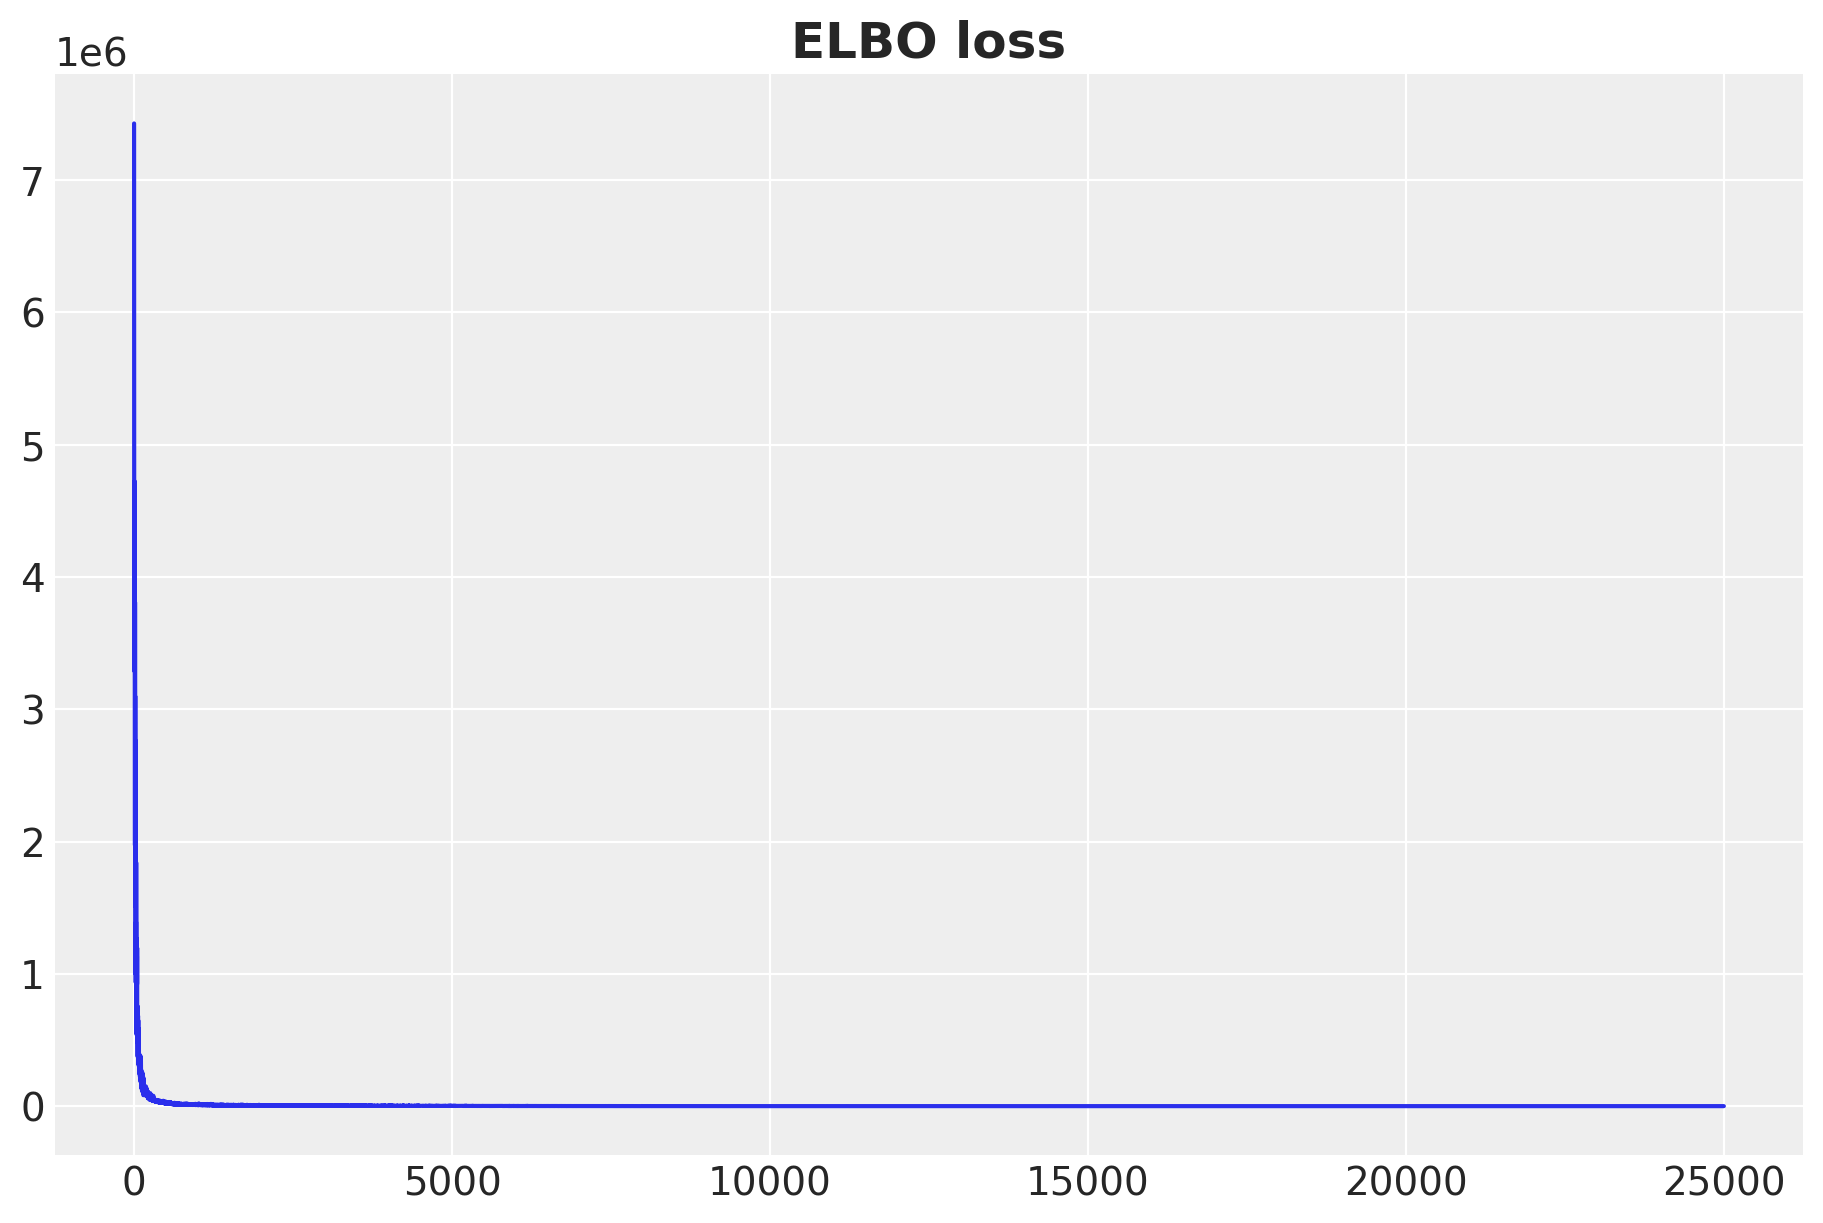

In [23]:
guide = AutoGuideList(reparam_hierarchical_elasticity_model)

rng_key, rng_subkey = random.split(key=rng_key)

guide.append(
    AutoNormal(
        block(
            seed(reparam_hierarchical_elasticity_model, rng_subkey),
            hide=[
                "beta_log_price_loc_decentered",
                "beta_log_price_loc",  # deterministic
                "beta_log_price_scale",
                "beta_log_price_prior",
                "beta_log_price",  # deterministic
                "sigma_sku_category",
                "sku_category",
            ],
        )
    )
)

rng_key, rng_subkey = random.split(key=rng_key)

guide.append(
    AutoMultivariateNormal(
        block(
            seed(reparam_hierarchical_elasticity_model, rng_subkey),
            expose=[
                "beta_log_price_loc_decentered",
                "beta_log_price_scale",
                "beta_log_price_prior",
                "sigma_sku_category",
                "sku_category",
            ],
        )
    )
)

optimizer = numpyro.optim.Adam(step_size=0.01)
svi = SVI(
    reparam_hierarchical_elasticity_model,
    guide,
    optimizer,
    loss=Trace_ELBO(),
)

num_steps = 25_000

rng_key, rng_subkey = random.split(key=rng_key)
svi_result = svi.run(
    rng_subkey,
    num_steps,
    log_price,
    sku_idx,
    date_idx,
    sku_category_idx,
    sku_category_mapping,
    log_quantity,
)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(svi_result.losses)
ax.set_title("ELBO loss", fontsize=18, fontweight="bold");

In [24]:
rng_key, rng_subkey = random.split(rng_key)
svi_posterior = Predictive(
    model=reparam_hierarchical_elasticity_model,
    guide=guide,
    params=svi_result.params,
    num_samples=5_000,
    return_sites=[
        "beta_log_price_loc",
        "beta_log_price_scale",
        "beta_log_price_prior",
        "beta_log_price",
        "sigma",
        "sku_intercept",
        "date_intercept",
        "sigma_sku_category",
    ],
)(
    rng_subkey,
    log_price,
    sku_idx,
    date_idx,
    sku_category_idx,
    sku_category_mapping,
    log_quantity,
)

svi_idata = az.from_dict(
    posterior={
        k: np.expand_dims(a=np.asarray(v), axis=0) for k, v in svi_posterior.items()
    },
    coords={"sku": sku, "sku_category": sku_category, "date": date},
    dims={
        "beta_log_price_loc": ["sku_category"],
        "beta_log_price_scale": ["sku_category"],
        "beta_log_price": ["sku"],
        "beta_log_price_prior": ["sku_category"],
        "sku_intercept": ["sku"],
        "date_intercept": ["date"],
        "sigma_sku_category": ["sku_category"],
    },
)

First of all, observe that this model allow us to compute elasticities at the SKU category level:

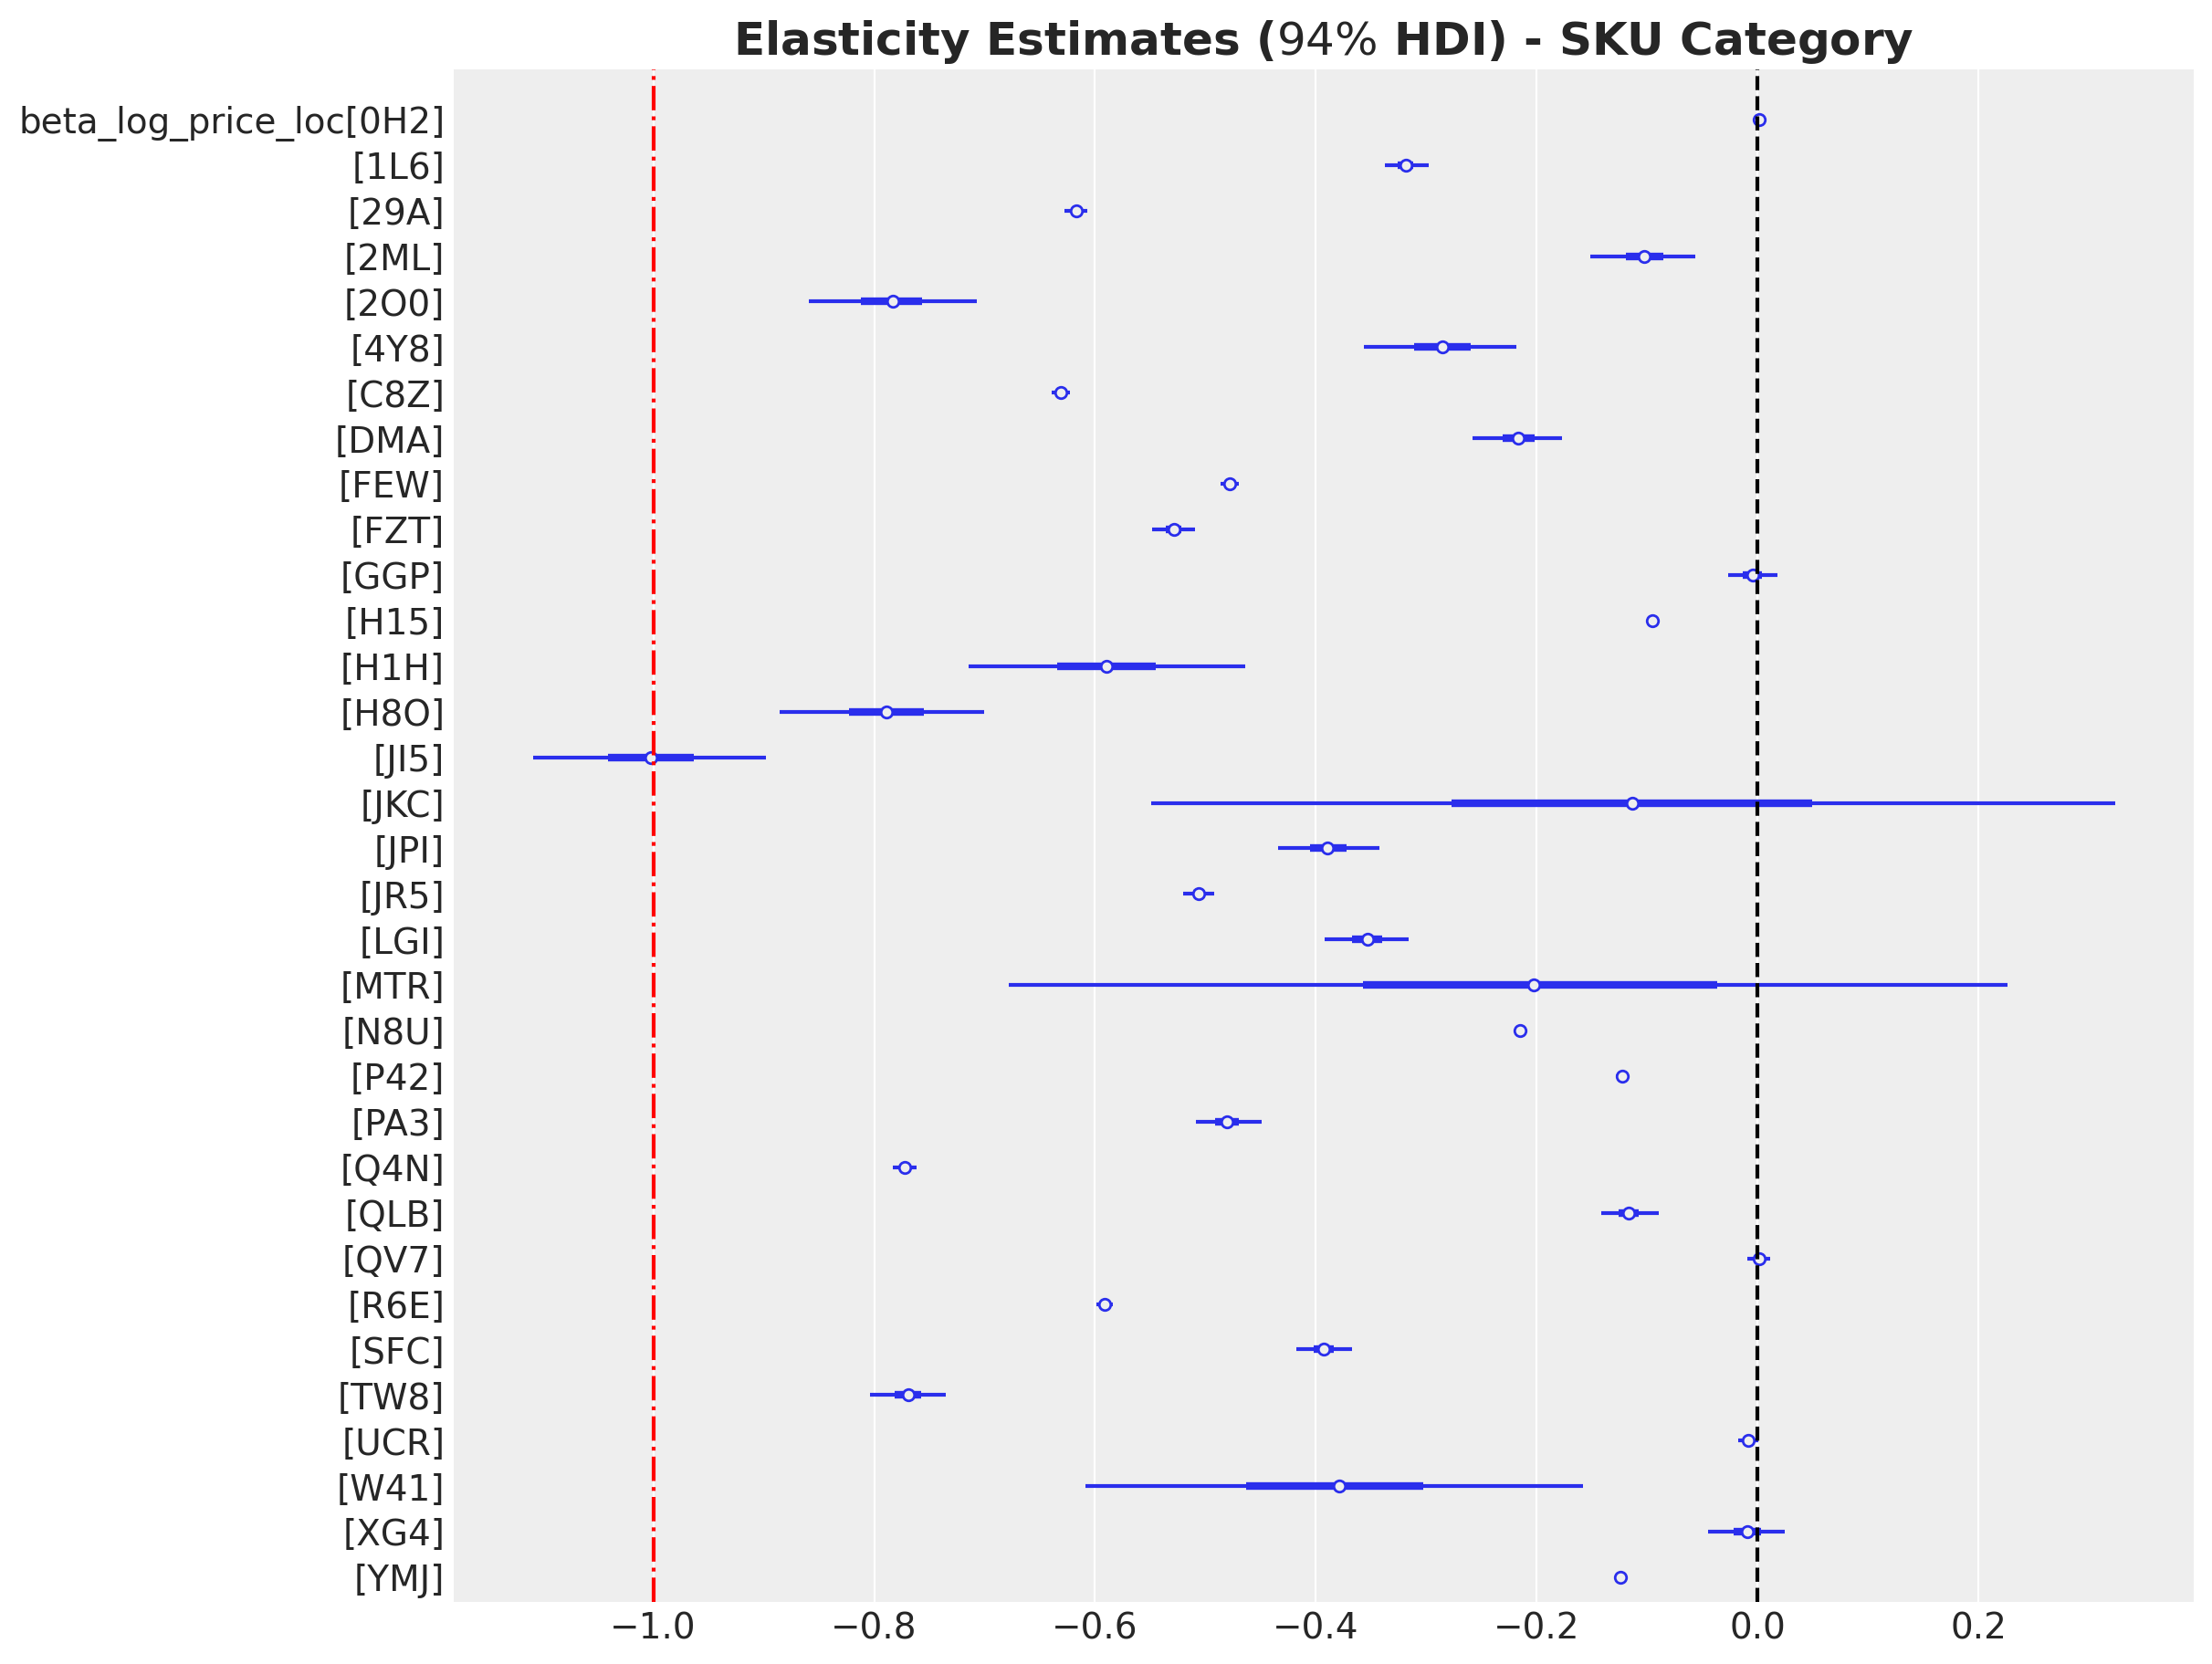

In [25]:
fig, ax = plt.subplots(figsize=(12, 9))
az.plot_forest(
    data=svi_idata,
    var_names=["beta_log_price_loc"],
    combined=True,
    ax=ax,
)
ax.axvline(x=0, color="black", linestyle="--")
ax.axvline(x=-1, color="red", linestyle="-.")
ax.set_title(
    r"Elasticity Estimates ($94\%$ HDI) - SKU Category", fontsize=18, fontweight="bold"
);

We see that the elasticities at the SKU category level are mostly negative as expected 😎! 

Next, we compare the elasticities of the three models at the SKU level.

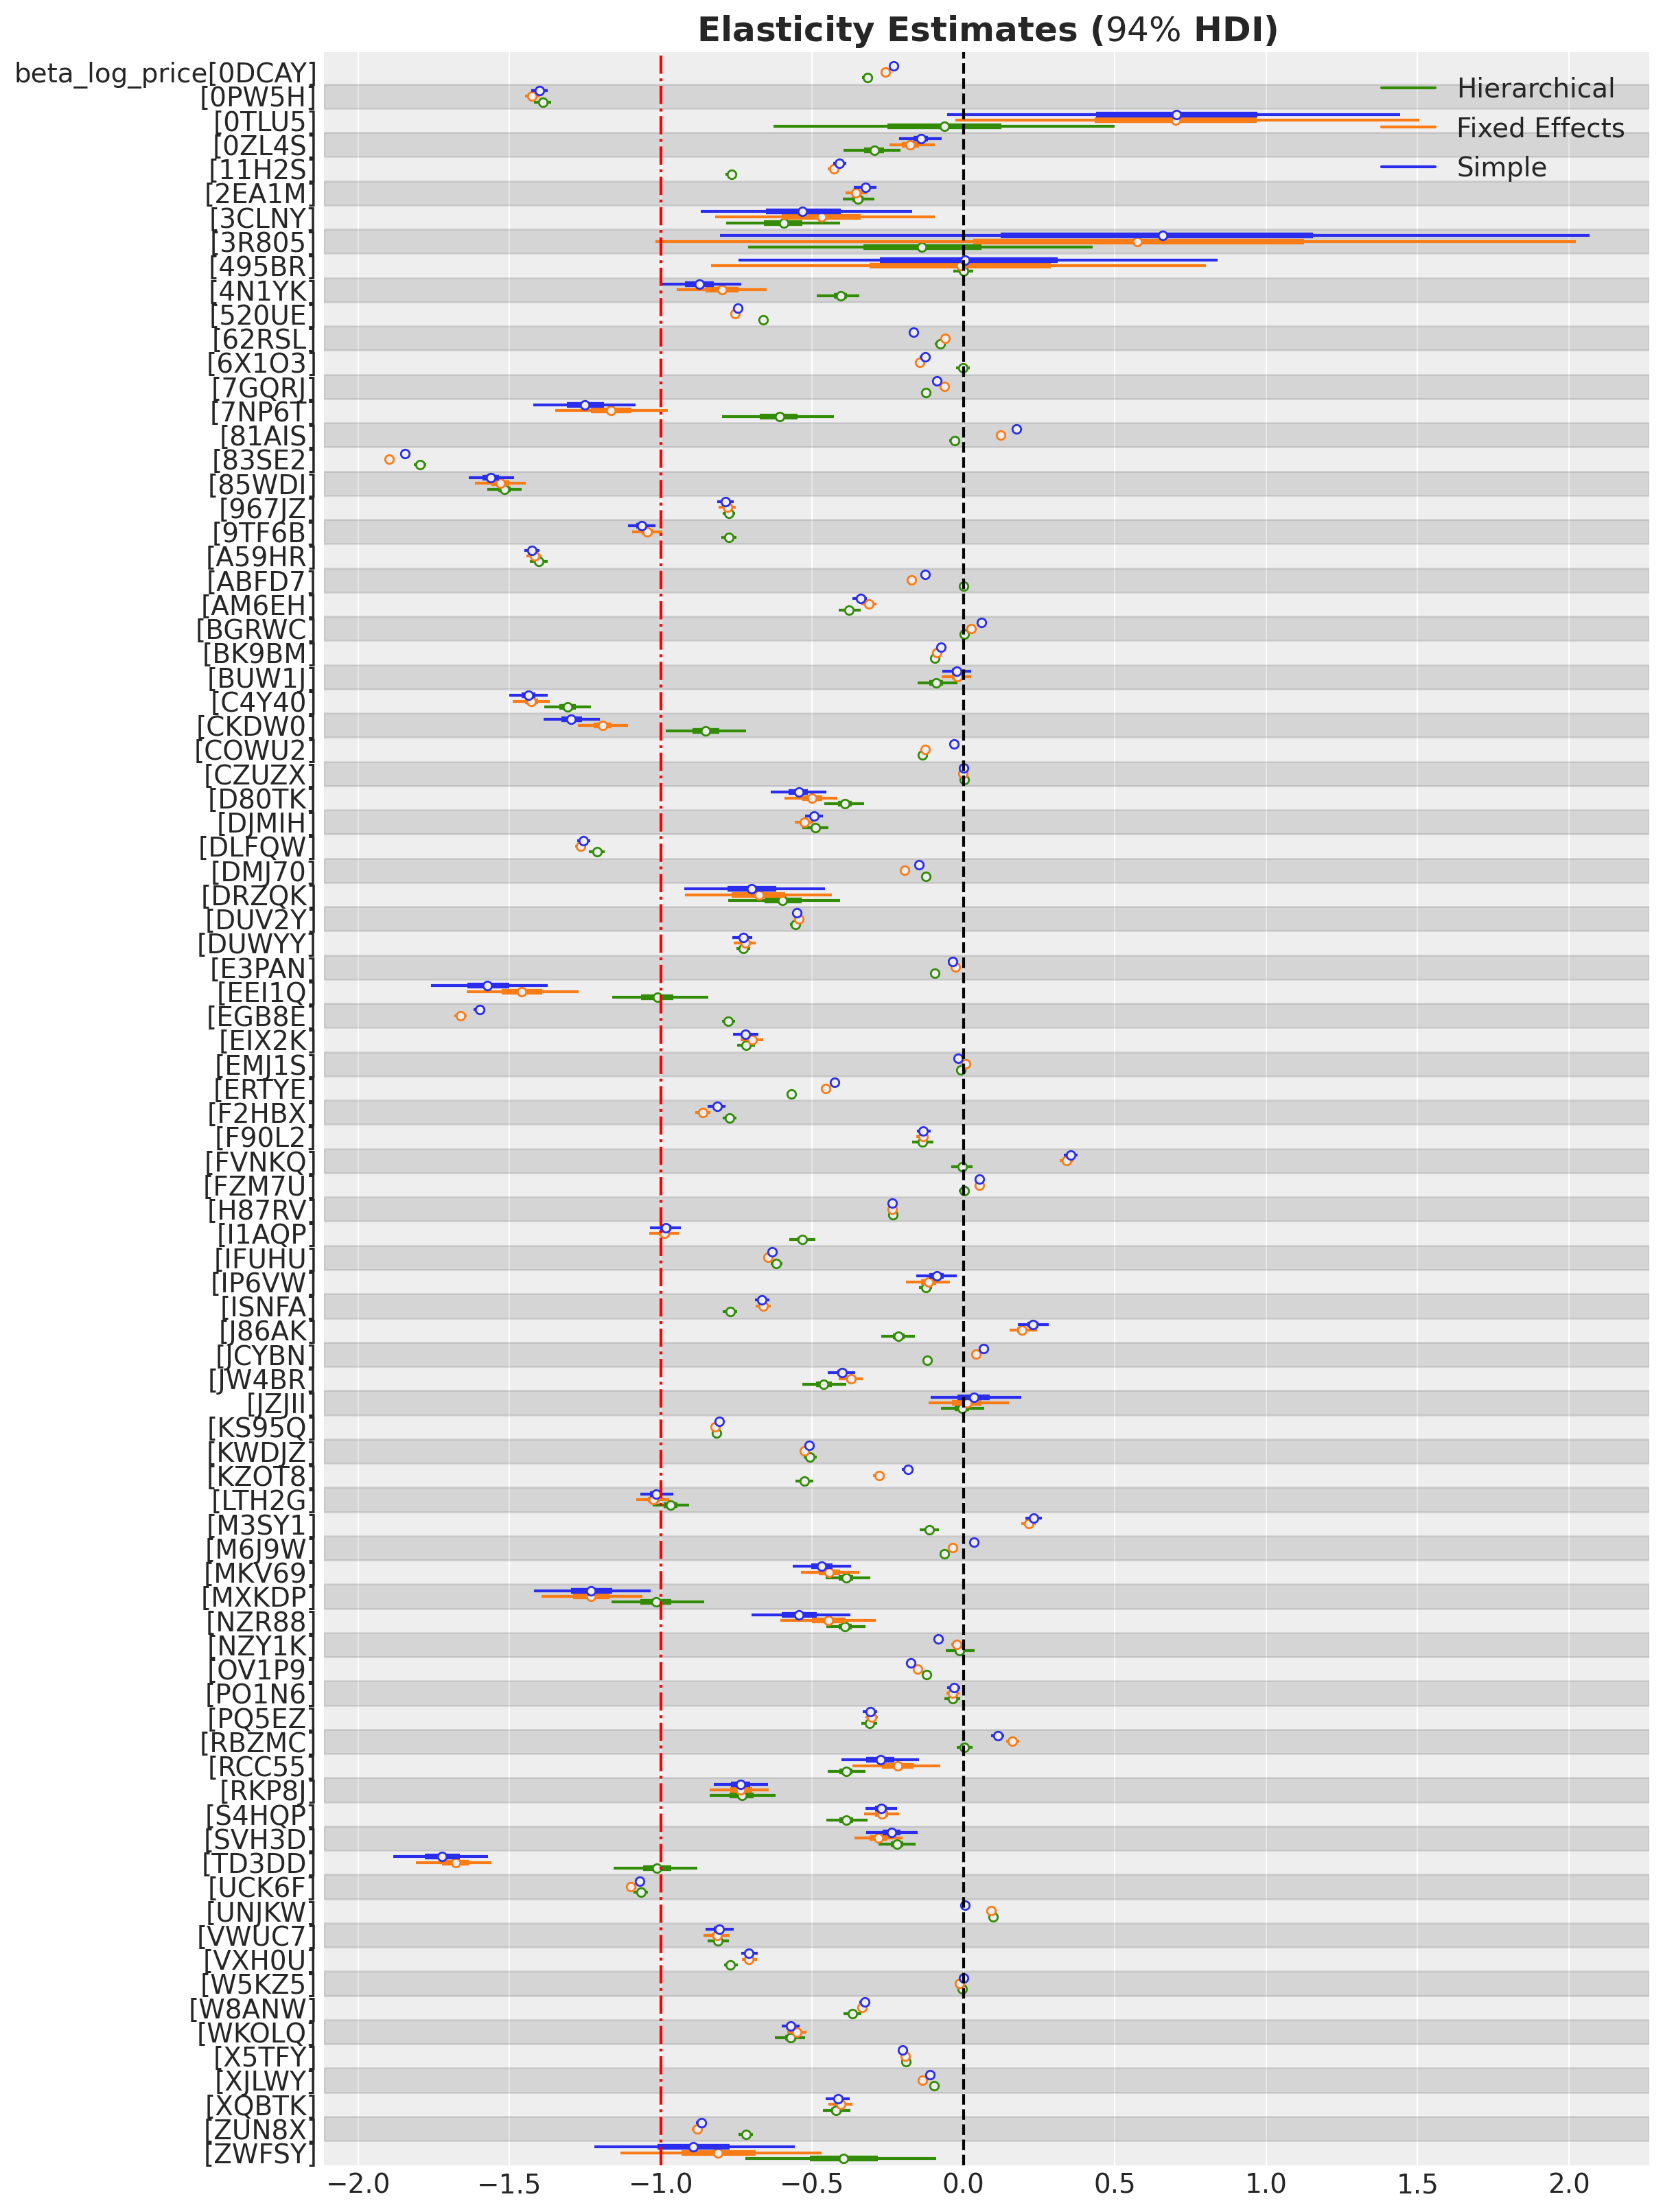

In [26]:
fig, ax = plt.subplots(figsize=(12, 16))
az.plot_forest(
    data=[simple_svi_idata, fixed_effects_svi_idata, svi_idata],
    model_names=["Simple", "Fixed Effects", "Hierarchical"],
    var_names=["beta_log_price"],
    combined=True,
    ax=ax,
)
ax.axvline(x=0, color="black", linestyle="--")
ax.axvline(x=-1, color="red", linestyle="-.")
ax.set_title(
    r"Elasticity Estimates ($94\%$ HDI)",
    fontsize=18,
    fontweight="bold",
);

We see how the hierarchical model brings the estimates to the global mean (i.e. **shrinkage**) and most of the elasticities are now negative as expected. For the SKUs that had negative elasticities in the simple and fixed-effects models, the hierarchical model estimates are very similar.

Moreover, we can decompose the elasticity estimate at SKU category level into the individual SKU estimates. Let us see for example the SKU category `29A`:

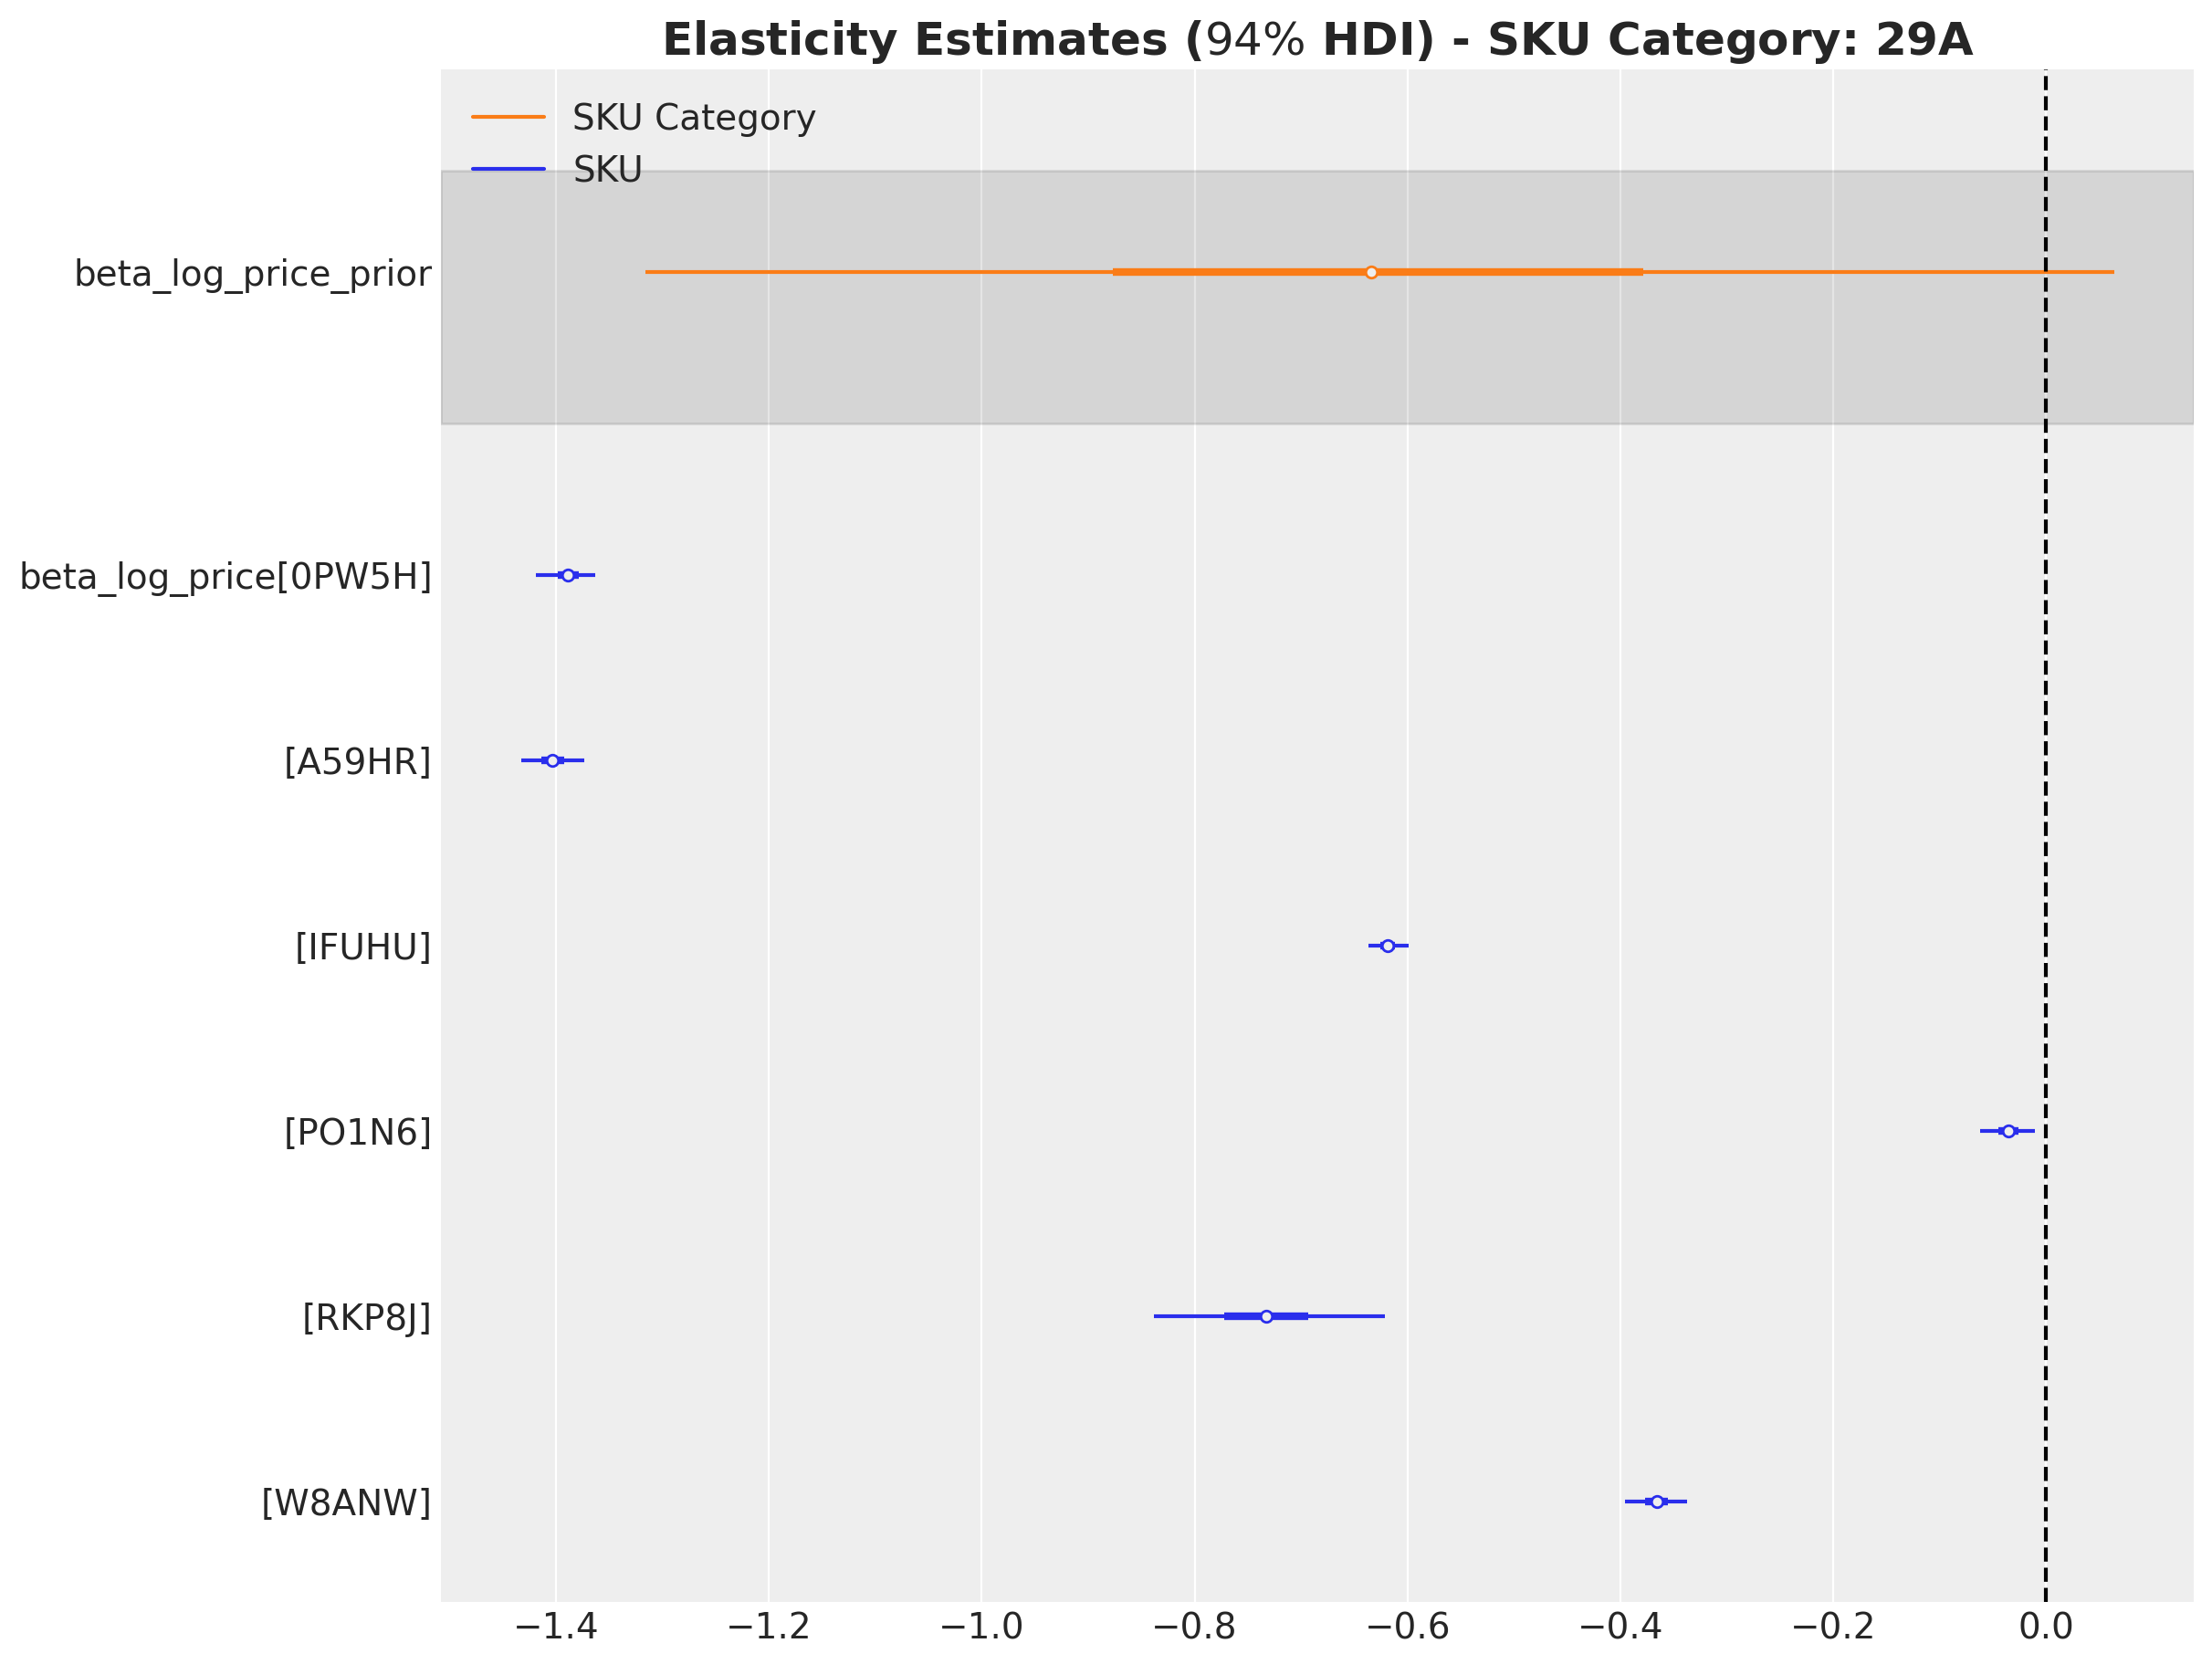

In [27]:
sku_category_idx_to_plot = 2

fig, ax = plt.subplots(figsize=(12, 9))
az.plot_forest(
    data=[
        (
            # Filter by SKU Category and select the associated SKUs.
            svi_idata["posterior"]["beta_log_price"][
                ...,
                np.isin(
                    sku,
                    sku_category_mapping_df.filter(
                        pl.col("sku_category") == sku_category[sku_category_idx_to_plot]
                    )["sku"].to_list(),
                ),
            ]
        ),
        # Filter by SKU Category.
        svi_idata["posterior"]["beta_log_price_prior"].sel(
            sku_category=sku_category[sku_category_idx_to_plot]
        ),
    ],
    model_names=["SKU", "SKU Category"],
    var_names=["beta_log_price_prior", "beta_log_price"],
    combined=True,
    ax=ax,
)
ax.axvline(x=0, color="black", linestyle="--")
ax.set_title(
    rf"Elasticity Estimates ($94\%$ HDI) - SKU Category: {sku_category[sku_category_idx_to_plot]}",  # noqa: E501
    fontsize=18,
    fontweight="bold",
);

Observe that the uncertainty of the SKU category includes all the elasticity estimates of the individual SKU categories.

Finally, we generate posterior predictive checks to check the fit of the model.

In [28]:
rng_key, rng_subkey = random.split(rng_key)
svi_posterior_predictive = Predictive(
    model=reparam_hierarchical_elasticity_model,
    params=svi_result.params,
    guide=guide,
    num_samples=5_000,
    return_sites=["obs"],
)(
    rng_subkey,
    log_price,
    sku_idx,
    date_idx,
    sku_category_idx,
    sku_category_mapping,
)

svi_idata.extend(
    az.from_numpyro(
        posterior_predictive=svi_posterior_predictive,
        coords={"obs": obs_idx},
        dims={"obs": ["obs_idx"]},
    )
)

Let's plot some individual SKU predictions.

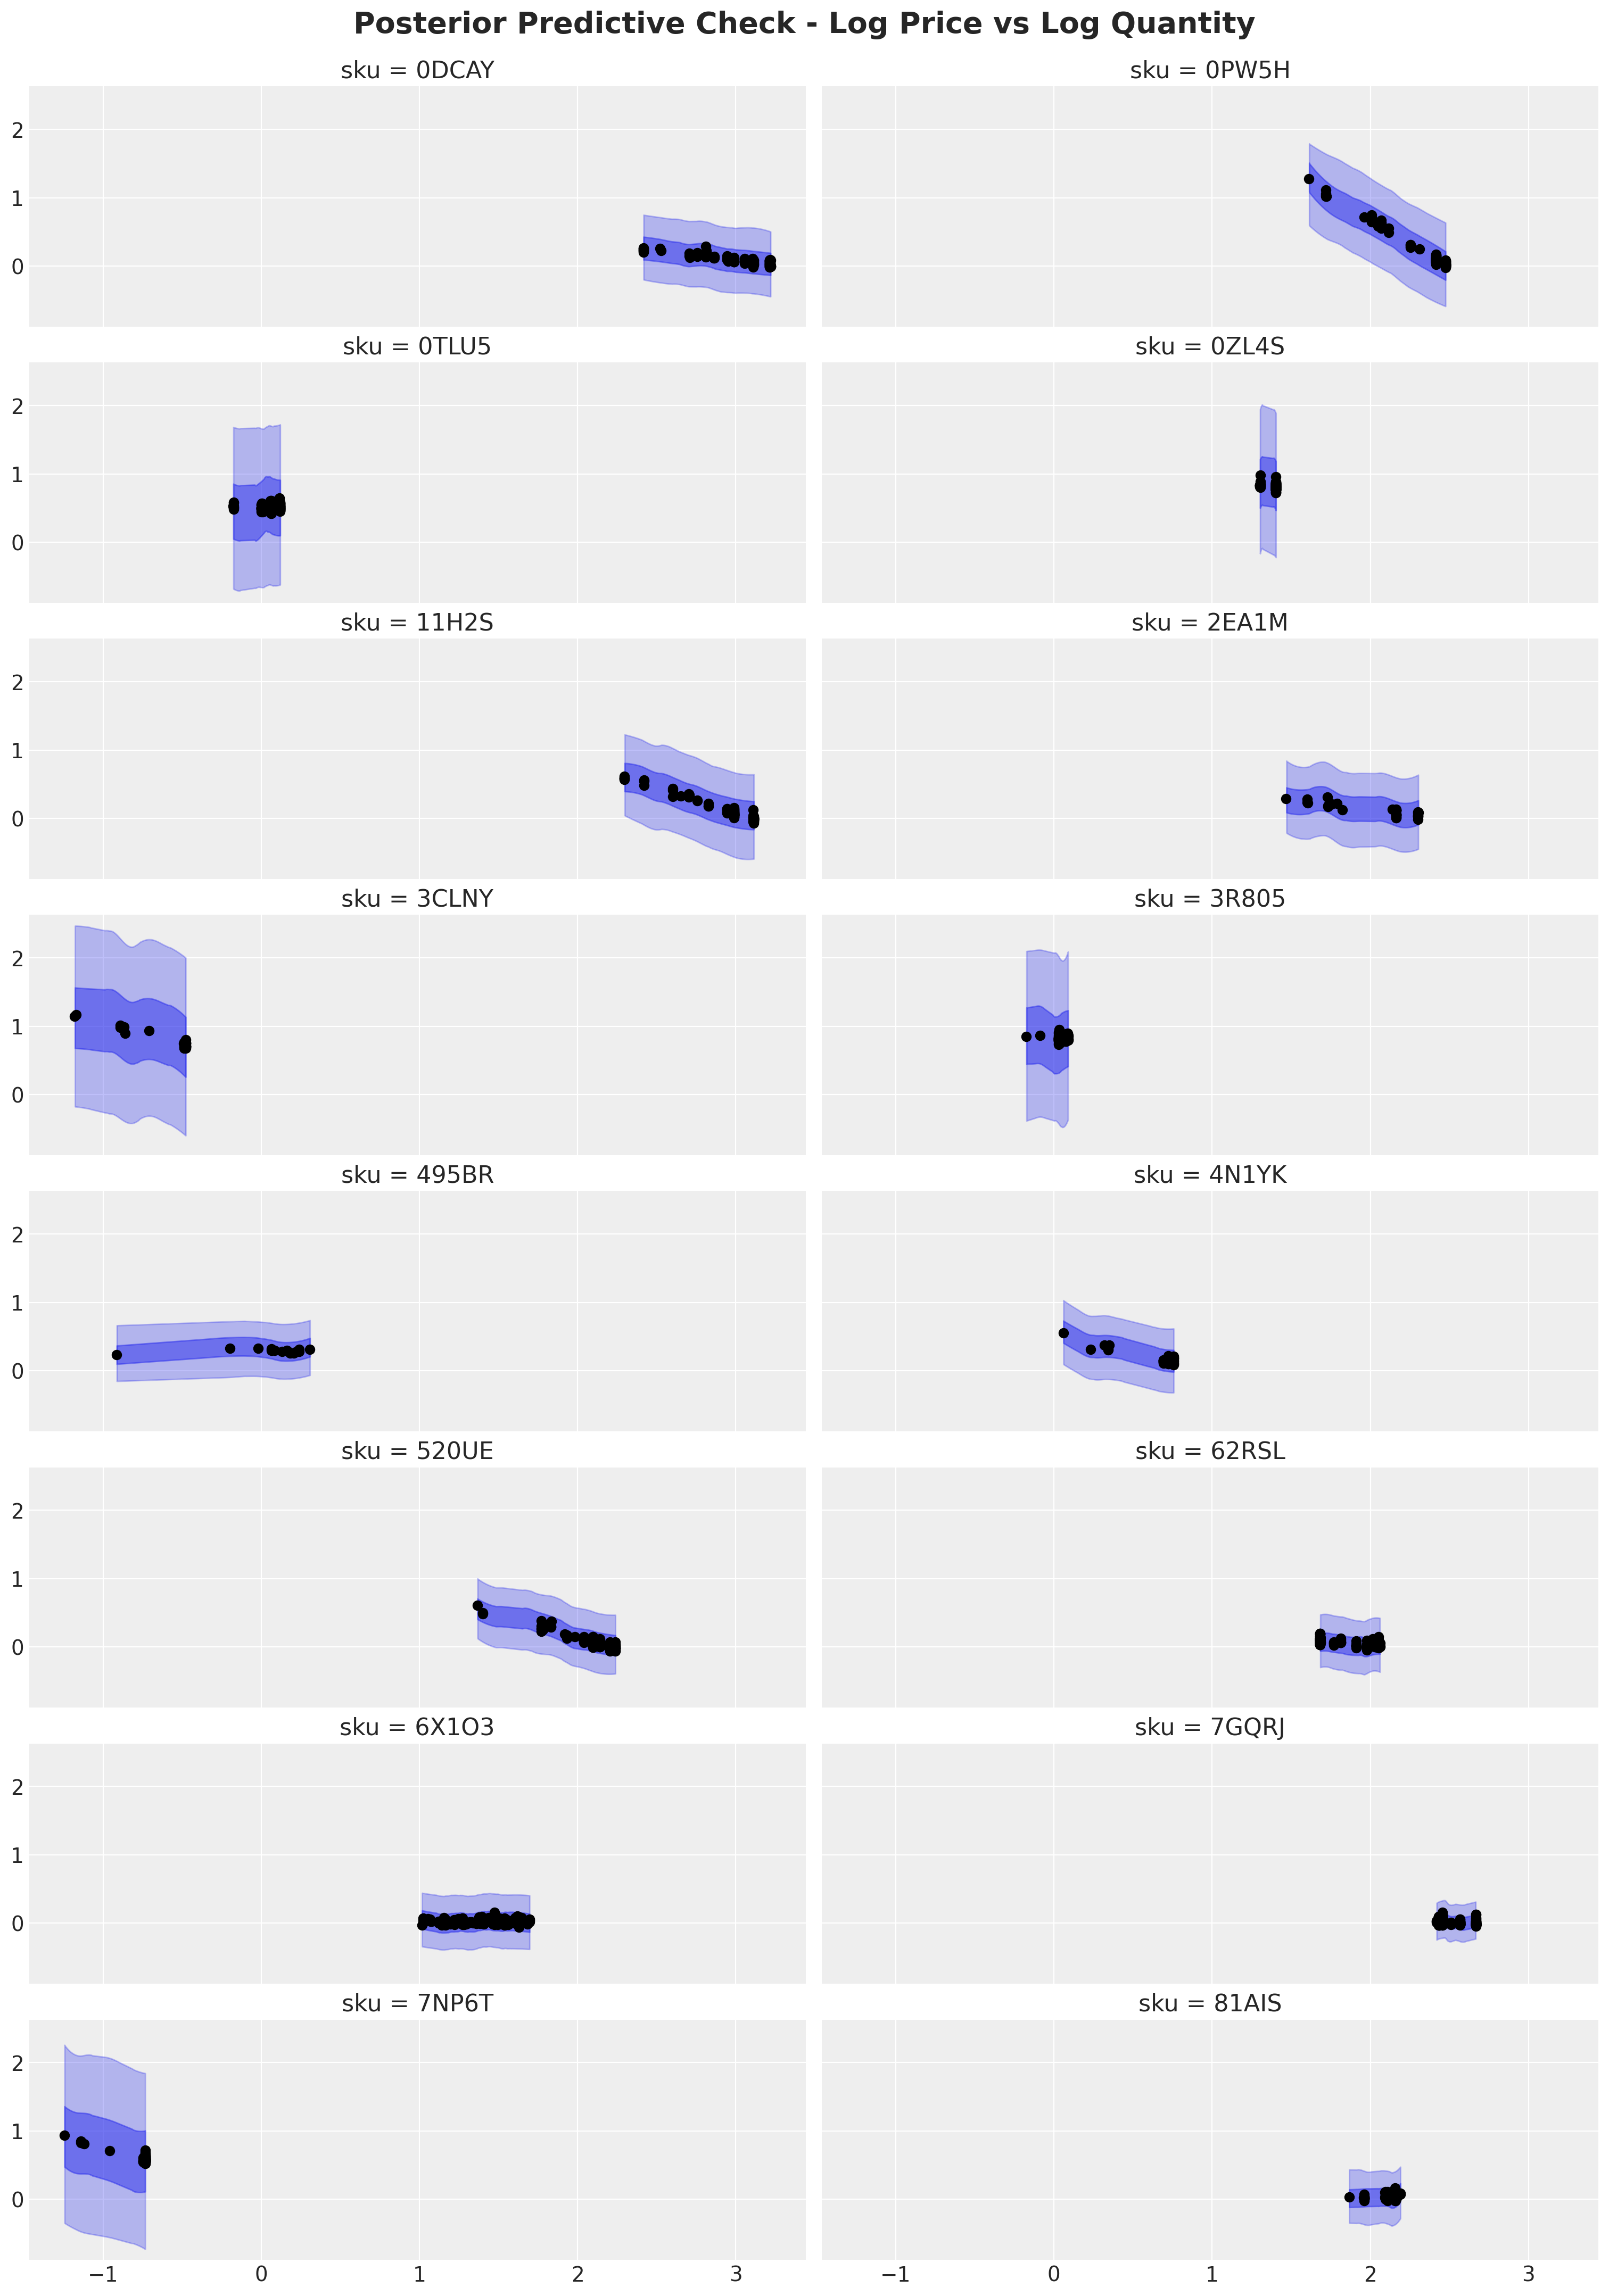

In [29]:
n_skus = 16

fig, axes = plt.subplots(
    nrows=n_skus // 2,
    ncols=2,
    figsize=(15, 21),
    sharex=True,
    sharey=True,
    layout="constrained",
)

axes = axes.flatten()

for _idx in range(n_skus):
    sku_idx_obs_posterior = svi_idata["posterior_predictive"]["obs"][
        :, :, (model_df["sku"] == sku[_idx])
    ]

    ax = axes[_idx]

    az.plot_hdi(
        model_df.filter(pl.col("sku") == sku[_idx])["log_price"],
        sku_idx_obs_posterior,
        hdi_prob=0.95,
        color="C0",
        fill_kwargs={"alpha": 0.3},
        ax=ax,
    )
    az.plot_hdi(
        model_df.filter(pl.col("sku") == sku[_idx])["log_price"],
        sku_idx_obs_posterior,
        hdi_prob=0.5,
        color="C0",
        fill_kwargs={"alpha": 0.5},
        ax=ax,
    )

    ax.scatter(
        model_df.filter(pl.col("sku") == sku[_idx])["log_price"],
        sku_idx_obs_posterior.mean(dim=("chain", "draw")),
        color="black",
    )

    ax.set(title=f"sku = {sku[_idx]}")

fig.suptitle(
    "Posterior Predictive Check - Log Price vs Log Quantity",
    fontsize=20,
    fontweight="bold",
    y=1.02,
);

Overall, the hierarchical model seems to fit the data well.

## Conclusion

In this notebook, we have conducted an in-depth analysis of price elasticities using a hierarchical Bayesian model for a publicly available retail dataset. We have seen how the hierarchical model allows us to regularize the elasticity estimates for noisy data. Moreover, even with a more complex guide, this type of model scales well to large datasets using stochastic variational inference. Of course, there is a big missing piece which is the inclusion of cross-elasticities terms. Even though this is not trivial, we believe we could use covariance methods like the one proposed by [Multilevel Elasticities for a Single SKU - Part III](https://juanitorduz.github.io/multilevel_elasticities_single_sku_3/) to include them in this type of model.